In [ ]:
# импортируем все зависимости
!pip install ray torch torchvision

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
import pickle

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import torch
from torch import nn, optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os 
import cv2
from tqdm.notebook import tqdm
import random
from functools import partial


from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

## Загрузка и препроцессинг данных

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/speechGender")
!ls

data	libritts_speakerinfo.txt  speaker_info_extractor.py  train100
images	model			  test


Мы будем использовать сжатый датасет LibriTTS для обучения нашей модели - он лежит в train-clean-100.zip. Файл test-clean.zip содежит тестовый датасет. Распакуем оба архива в папки train100 и test соответственно. Информация о всех спикерах LibriTTS хранится в файле libritts_speakerinfo.txt.

In [ ]:
!unzip "/content/drive/My Drive/speechGender/train-clean-100.zip" -d "/content/drive/My Drive/speechGender/train100"

In [ ]:
!unzip "/content/drive/My Drive/speechGender/test-clean.zip" -d "/content/drive/My Drive/speechGender/test"

Далее с помощью скрипта speaker_info_extractor.py из текстового файла libritts_speakerinfo.txt с информацией о спикерах была извлечена информация о полах только тех спикеров, чья речь используется в train100. 

После выполнения программы имеем файлы train_speaker_info.npy и test_speaker_info.npy с метками пола для id используемых спикеров.

In [ ]:
with open('data/train_speaker_info.npy', 'rb') as f_train:
    train_classes = np.load(f_train)
with open('data/test_speaker_info.npy', 'rb') as f_test:
    test_classes = np.load(f_test)
train_classes = train_classes.astype(int)
train_speakers = train_classes[:,0]

test_classes = test_classes.astype(int)
test_speakers = test_classes[:,0]

### Извлечение путей до файлов для каждого спикера

In [ ]:
# сохраним в словарь dict_train_path все пути к аудиофайлам обучающей выборки
# (для каждого ключа-id спикера храним список путей до их аудиозаписей)

dict_train_path = {}
for speaker in tqdm(train_speakers):
    dict_train_path[speaker] = []
    for root, dirs, files in os.walk('train100/' + str(speaker)):
        for f in files:
            if '.wav' in f:
                dict_train_path[speaker].append(root +'/' +f)

  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
# то же самое для тестовой выборки

dict_test_path = {}
for speaker in tqdm(test_speakers):
    dict_test_path[speaker] = []
    for root, dirs, files in os.walk('test/test-clean/' + str(speaker)):
        for f in files:
            if '.wav' in f:
                dict_test_path[speaker].append(root +'/' +f)

  0%|          | 0/40 [00:00<?, ?it/s]

### Примеры записей мужского и женского голоса

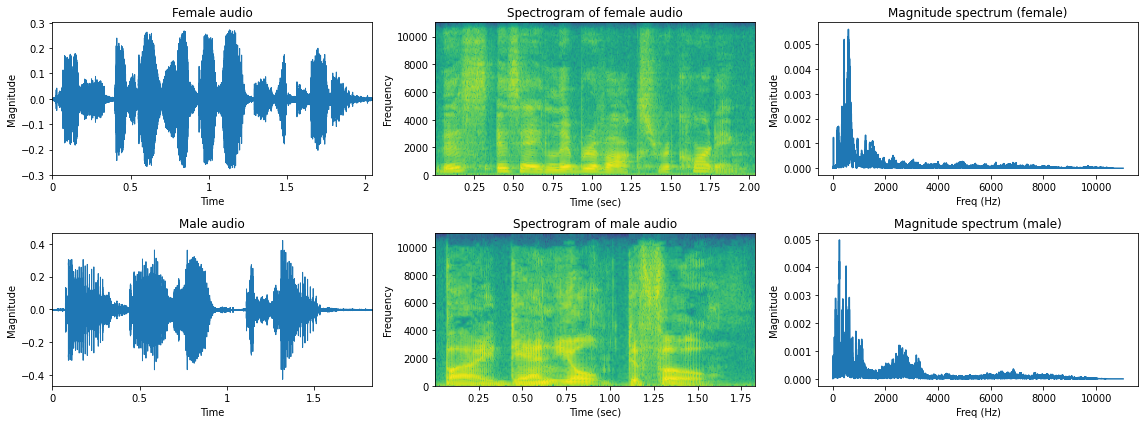

In [ ]:
# для примеров записей женского и мужского голоса выведем на экран графики
# аудиосигнала как амплитуды ко времени, спектрограммы и спектры магнитуды

female_audio,sample_rate_f=librosa.core.load(
    '/content/drive/My Drive/speechGender/train100/19/198/19_198_000000_000000.wav')
male_audio, sample_rate_m=librosa.core.load(
    '/content/drive/My Drive/speechGender/train100/26/495/26_495_000004_000000.wav')

dirname='images'

if not os.path.isdir(dirname):
      os.makedirs(dirname)

plt.figure(figsize=(16,6))
plt.subplot(231)
librosa.display.waveplot(
    female_audio,sample_rate_f,max_points=50000, x_axis='time', offset=0.0, max_sr=1000)
plt.ylabel('Magnitude')
plt.title('Female audio')

plt.subplot(232)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(female_audio, Fs=sample_rate_f)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Spectrogram of female audio')

plt.subplot(233)
plt.magnitude_spectrum(female_audio, Fs = sample_rate_f) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude spectrum (female)')

plt.subplot(234)
librosa.display.waveplot(
    male_audio,sample_rate_m, max_points=50000, x_axis='time', offset=0.0, max_sr=1000)
plt.ylabel('Magnitude')
plt.title('Male audio')

plt.subplot(235)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(male_audio, Fs=sample_rate_m)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Spectrogram of male audio')

plt.subplot(236)
plt.magnitude_spectrum(male_audio, Fs = sample_rate_m) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude spectrum (male)')

# сохраним вывод в 'images/spectrum.png'

plt.tight_layout()
plt.savefig(f'{dirname}/spectrum.png')
plt.show() 

## Извлечение признаков

In [ ]:
def feature_extraction(file_name, feature_name):
  
  # метод для извлечения признаков из аудиозаписи
  # принимает аргументы file_name: путь до аудиофайла, 
  # и feature_name: название набора признаков, которые можно извлечь 
  # (допустимые значения: ["mfcc", "mel", "chroma", "tonnetz", "contrast"])

  audio, sample_rate = librosa.core.load(file_name)

  if feature_name=="mfcc":
    features=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=25).T, axis=0)
  if feature_name=="chroma":
    EnrgSpectra = np.abs(librosa.stft(audio))
    features=np.mean(librosa.feature.chroma_stft(S=EnrgSpectra, sr=sample_rate).T, axis=0)
  if feature_name=="mel":
    features = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T, axis=0)
  if feature_name=="tonnetz":
    features=np.mean(librosa.feature.tonnetz(y=audio,sr=sample_rate).T, axis=0)
  if feature_name=="contrast":
    features=np.mean(librosa.feature.spectral_contrast(y=audio,sr=sample_rate).T, axis=0)

  features=preprocessing.scale(features)

  return features

Для обучения модели я решила использовать набор признаков, извлеченных с помощью мелспектрограммы: мы будем брать среднее значение по каждому бину и таким образом запоминать насыщенность каждого из 128ми рангов частот для каждой аудиозаписи. 

В дальнейшем мы построим сверточную нейросеть со слоями Conv1d, извлекающую информацию из таких признаков.


In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)
feature_list, label = [], []

# извлекаем признаки для все аудиозаписей каждого из спикеров
# и кладем признаки в лист features, а соответствующие метки - в список label

for speaker, sex in tqdm(train_classes):
    for f in dict_train_path[speaker]:
          features=feature_extraction(f, "mel")
          feature_list.append(features)
          if sex== 0:
              label.append(1)
          else: 
              label.append(0)


  0%|          | 0/251 [00:00<?, ?it/s]

Теперь сохраним извлеченные признаки всех аудиозаписей в файлы all_audio_features.npy и all_labels.npy чтобы не повторять длительный процесс их подсчета - далее обучение можно воспроизвести просто загрузив эти файлы в переменные X и Y:

In [ ]:
Y=np.array(label).reshape(len(label),1)
X=np.array(feature_list).reshape(len(feature_list), len(features))

dirname="data"

if not os.path.isdir(dirname):
  os.mkdir(dirname)

np.save("data/all_train_audio_features.npy", X)
np.save("data/all_train_labels.npy", Y)

Делаем то же самое для тестовой выборки.

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

feature_list_test, label_test = [], []

for speaker, sex in tqdm(test_classes):
    for f in dict_test_path[speaker]:
          features=feature_extraction(f, "mel")
          feature_list_test.append(features)
          if sex== 0:
              label_test.append(1)
          else: 
              label_test.append(0)
  
Y=np.array(label_test).reshape(len(label_test),1)
X=np.array(feature_list_test).reshape(len(feature_list_test), len(features))



np.save("data/all_test_audio_features.npy", X)
np.save("data/all_test_labels.npy", Y)

  0%|          | 0/40 [00:00<?, ?it/s]

## Загрузка X_train, X_test, Y_train, Y_test

In [ ]:
# методы загрузки признаков X и меток Y для всех аудиофайлов
# из обучающей и тестовой выборок соответственно

def load_data_train():
  X=np.load("/content/drive/My Drive/speechGender/data/all_train_audio_features.npy")
  Y=np.load("/content/drive/My Drive/speechGender/data/all_train_labels.npy")
  
  return X, Y

def load_data_test():
  X=np.load("/content/drive/My Drive/speechGender/data/all_test_audio_features.npy")
  Y=np.load("/content/drive/My Drive/speechGender/data/all_test_labels.npy")
  
  return X, Y

In [ ]:
# загружаем обучающие и тестовые датасеты с признаками и метками

X_train, Y_train = load_data_train()
X_test, Y_test = load_data_test()

np.random.seed(42)
X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)

print(X_test.shape)

(4837, 128)


## Построение CNN модели

In [ ]:
class MelDataset(Dataset):
    def __init__(self, mel, labels):
        self.labels = labels
        self.mel = mel
    def __len__(self):
        return self.labels.shape[0]
    def __getitem__(self, idx):
        label = self.labels[idx]
        mel = self.mel[idx]
        return mel, label

In [ ]:
# строим класс нашей CNN модели

class Model(nn.Module):
    def __init__(self, inp_size=X_train.shape[1]):
        super().__init__()
        self.inp_size = inp_size 
        layers = []
        layers += [
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=2,padding=1, bias=False),
            nn.BatchNorm1d(32, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2,padding=1, bias=False),
            nn.BatchNorm1d(64, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1,padding=1, bias=False),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(inp_size//(2**5)*128,32),
            nn.Linear(32,1),
            nn.Sigmoid()]
        self.blocks = nn.Sequential(*layers)
    
    def forward(self, x):
        res = self.blocks(x)
        return res
        


## Обучение CNN модели

### Тьюнинг гиперпараметров с помощью Ray Tune
Попробуем подобрать лучшие гиперпараметры для обучения нашей сверточной нейронной сети. Будем использовать Tune из PyTorch для случайного варьирования гиперпараметров. Сперва напишем обучающую функцию:

In [ ]:
def train_n_tune(config, checkpoint_dir=None, data_dir=None):
    model = Model()
    train_loss_all, test_loss_all = [], []

    # проверяем доступен ли нам gpu, если да - переключаемся на него

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # объявляем функцию потерь  и оптимизатор

    criterion =  F.binary_cross_entropy
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)

    # загружаем информацию о предобученной модели и оптимизаторе
    # если она уже лежит в папке

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_dataset = MelDataset(X_train, Y_train)
    test_dataset = MelDataset(X_test, Y_test)

    # разделяем трейн на обучающую и валидационную подвыборки

    test_abs = int(len(train_dataset) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset, [test_abs, len(train_dataset) - test_abs])

    trainloader = DataLoader(train_subset, batch_size=int(config["batch_size"]), shuffle=True)
    valloader = DataLoader(val_subset, batch_size=int(config["batch_size"]), shuffle=True)

    for epoch in range(config["epochs"]):
        running_loss = 0.0
        epoch_steps = 0
        for i, (inputs, labels) in enumerate(trainloader):
            if len(inputs) < int(config["batch_size"]):
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.reshape((int(config["batch_size"]), 1, -1))
            labels = labels.type(torch.float)

            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # считаем бинарную кросс энтропию и выводим через каждые 2000 элементов
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # считаем лосс и аккураси на валидационной выборке
        val_loss = 0.0
        val_steps = 0
        total = len(val_subset)
        correct = 0
        for i, (inputs, labels) in enumerate(valloader):
            if len(inputs) < int(config["batch_size"]):
                continue
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.reshape((int(config["batch_size"]), 1, -1))
                labels = labels.type(torch.float)


                outputs = model(inputs)

                predicted = torch.Tensor([1 if p>=0.5 else 0 for p in outputs]).reshape(-1,1).to(device)
                correct += (predicted == labels).float().sum()

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_steps += 1
        

        train_loss_all.append(running_loss / epoch_steps)
        test_loss_all.append(int(val_loss) / val_steps)

        # сохраняем информацию о состоянии модели и оптимизатора

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(int(val_loss) / val_steps), accuracy=correct / total, 
                    train_list = train_loss_all, test_list = test_loss_all)
    print("Обучение закончено!")

Далее непосредственно варьируем гиперапараметры: learning rate, размер батча и количество эпох, и ищем наилучший набор параметров (с наименьшим значением функции потерь после обучения).

Выводим информацию о наилучших значениях гиперпараметров.

In [ ]:
num_samples=20
max_num_epochs=20
gpus_per_trial=0

if not os.path.isdir('./data/test'):
  os.mkdir('./data/test')

data_dir = os.path.abspath("/data/test")

config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([4, 6, 8, 12, 16]),
    "epochs": tune.choice([10, 20])
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    parameter_columns=[ "lr", "batch_size", "epochs"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_n_tune, data_dir=data_dir),
    resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))



2022-02-15 16:27:49,882	WARNING experiment.py:256 -- No name detected on trainable. Using DEFAULT.
2022-02-15 16:27:49,885	INFO registry.py:70 -- Detected unknown callable for trainable. Converting to class.
2022-02-15 16:27:50,353	WARNING callback.py:115 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-02-15 16:27:59,256	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:27:59 (running for 00:00:08.94)
Memory usage on this node: 3.7/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 16/20 (16 PENDING)
+---------------------+----------+-------+-------------+--------------+----------+
| Trial name          | status   | loc   |          lr |   batch_size |   epochs |
|---------------------+----------+-------+-------------+--------------+----------|
| DEFAULT_37b7c_00000 | PENDING  |       | 0.00168294  |           12 |       20 |
| DEFAULT_37b7c_00001 | PENDING  |       | 1.23473e-05 |           16 |       10 |
| DEFAULT_37b7c_00002 | PENDING  |       | 0.00013657  |           16 |       20 |
| DEFAULT_37b7c_00003 | PENDING  |       | 0.00399305  |            8 |

2022-02-15 16:27:59,885	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-02-15 16:28:00,476	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.
2022-02-15 16:28:01,097	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.
2022-02-15 16:28:01,559	WARNING worker.py:1257 -- Warning: The actor ImplicitFunc is very large (37 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-02-15 16:28:02,359	WARNING util.py:164 -- The `start_trial` operation took 1.254 s, which may be a performance bottleneck.
2022-02-15 16:28:05,403	WARNING util.py:164 -- The `start_trial` operation took 0.607 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:05 (running for 00:00:15.16)
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |
|---------------------+----------+-----------------+-------------+--------------+----------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 |
| DEFAULT_37b7c_00001 | RUNNING  | 172.28.0.2:9551 | 1.23473e-05 |           16 |       10 |
| DEFAULT_37b7c_00002 | PENDING  |                 | 0.00013657  |           16 |       20 

2022-02-15 16:28:08,368	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-02-15 16:28:09,228	WARNING util.py:164 -- The `start_trial` operation took 0.756 s, which may be a performance bottleneck.
2022-02-15 16:28:10,026	WARNING util.py:164 -- The `start_trial` operation took 0.663 s, which may be a performance bottleneck.
2022-02-15 16:28:10,825	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:10 (running for 00:00:20.58)
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |
|---------------------+----------+-----------------+-------------+--------------+----------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 |
| DEFAULT_37b7c_00001 | RUNNING  | 172.28.0.2:9551 | 1.23473e-05 |           16 |       10 |
| DEFAULT_37b7c_00002 | PENDING  |                 | 0.00013657  |           16 |       20 

2022-02-15 16:28:11,623	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2022-02-15 16:28:12,378	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.
2022-02-15 16:28:13,219	WARNING util.py:164 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.
2022-02-15 16:28:14,060	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
2022-02-15 16:28:14,728	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.
2022-02-15 16:28:15,365	WARNING util.py:164 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:16 (running for 00:00:26.01)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |
|---------------------+----------+-----------------+-------------+--------------+----------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 |
| DEFAULT_37b7c_00001 | RUNNING  | 172.28.0.2:9551 | 1.23473e-05 |           16 |       10 |
| DEFAULT_37b7c_00002 | PENDING  |                 | 0.00013657  |           16 |       20 

2022-02-15 16:28:17,090	WARNING util.py:164 -- The `start_trial` operation took 0.706 s, which may be a performance bottleneck.
2022-02-15 16:28:18,821	WARNING util.py:164 -- The `start_trial` operation took 0.714 s, which may be a performance bottleneck.
2022-02-15 16:28:20,634	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:21 (running for 00:00:31.28)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |
|---------------------+----------+-----------------+-------------+--------------+----------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 |
| DEFAULT_37b7c_00001 | RUNNING  | 172.28.0.2:9551 | 1.23473e-05 |           16 |       10 |
| DEFAULT_37b7c_00002 | PENDING  |                 | 0.00013657  |           16 |       20 

2022-02-15 16:28:22,455	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.
2022-02-15 16:28:24,075	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.
2022-02-15 16:28:25,758	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:26 (running for 00:00:36.41)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |
|---------------------+----------+-----------------+-------------+--------------+----------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 |
| DEFAULT_37b7c_00001 | RUNNING  | 172.28.0.2:9551 | 1.23473e-05 |           16 |       10 |
| DEFAULT_37b7c_00002 | PENDING  |                 | 0.00013657  |           16 |       20 

2022-02-15 16:28:27,442	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.


(func pid=9552) [1,  2000] loss: 0.307


2022-02-15 16:28:29,114	WARNING util.py:164 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.
2022-02-15 16:28:30,851	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.6529)
  date: 2022-02-15_16-28-31
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.6602409638554216
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  time_since_restore: 23.29303526878357
  time_this_iter_s: 23.29303526878357
  time_total_s: 23.29303526878357
  timestamp: 1644942511
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  training_iteration: 1
  trial_id: 37b7c_00001
  


2022-02-15 16:28:32,254	WARNING util.py:164 -- The `start_trial` operation took 0.756 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:33 (running for 00:00:42.90)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6602409638554216
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 |          |            |     

2022-02-15 16:28:33,800	WARNING util.py:164 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.8875)
  date: 2022-02-15_16-28-33
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.259927797833935
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  time_since_restore: 26.964975833892822
  time_this_iter_s: 26.964975833892822
  time_total_s: 26.964975833892822
  timestamp: 1644942513
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  training_iteration: 1
  trial_id: 37b7c_00000
  


2022-02-15 16:28:34,326	WARNING util.py:164 -- The `start_trial` operation took 0.510 s, which may be a performance bottleneck.
2022-02-15 16:28:35,187	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.
2022-02-15 16:28:36,812	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.
2022-02-15 16:28:38,508	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:39 (running for 00:00:49.18)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.259928 |   0.887519 |     

2022-02-15 16:28:40,235	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:28:41,942	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.
2022-02-15 16:28:43,540	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:44 (running for 00:00:54.18)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.259928 |   0.887519 |     

2022-02-15 16:28:45,274	WARNING util.py:164 -- The `start_trial` operation took 0.709 s, which may be a performance bottleneck.
2022-02-15 16:28:46,999	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.
2022-02-15 16:28:48,594	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:49 (running for 00:00:59.25)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.259928 |   0.887519 |     

2022-02-15 16:28:50,383	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.
2022-02-15 16:28:52,033	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.6952)
  date: 2022-02-15_16-28-52
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.6289156626506024
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  time_since_restore: 44.79872488975525
  time_this_iter_s: 21.50568962097168
  time_total_s: 44.79872488975525
  timestamp: 1644942532
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  training_iteration: 2
  trial_id: 37b7c_00001
  


2022-02-15 16:28:53,554	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.


(func pid=9552) [2,  2000] loss: 0.214


2022-02-15 16:28:55,254	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:28:56 (running for 00:01:05.91)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.6289156626506024 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.259928 |   

2022-02-15 16:28:56,939	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:28:58,550	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9104)
  date: 2022-02-15_16-28-58
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.2148014440433213
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  time_since_restore: 52.138145446777344
  time_this_iter_s: 25.17316961288452
  time_total_s: 52.138145446777344
  timestamp: 1644942538
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  training_iteration: 2
  trial_id: 37b7c_00000
  


2022-02-15 16:28:59,977	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.
2022-02-15 16:29:01,715	WARNING util.py:164 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:02 (running for 00:01:12.40)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.214801 |   

2022-02-15 16:29:03,463	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:29:05,144	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.
2022-02-15 16:29:06,849	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:07 (running for 00:01:17.50)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.214801 |   

2022-02-15 16:29:09,926	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.
2022-02-15 16:29:13,672	WARNING util.py:164 -- The `start_trial` operation took 1.281 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.7292)
  date: 2022-02-15_16-29-14
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.6
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  time_since_restore: 66.60516095161438
  time_this_iter_s: 21.80643606185913
  time_total_s: 66.60516095161438
  timestamp: 1644942554
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  training_iteration: 3
  trial_id: 37b7c_00001
  
== Status ==
Current time: 2022-02-15 16:29:14 (running for 00:01:24.00)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB

2022-02-15 16:29:15,459	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.
2022-02-15 16:29:17,140	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.
2022-02-15 16:29:18,778	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.


(func pid=9552) [3,  2000] loss: 0.196
== Status ==
Current time: 2022-02-15 16:29:19 (running for 00:01:29.43)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  | 

2022-02-15 16:29:20,440	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.
2022-02-15 16:29:22,224	WARNING util.py:164 -- The `start_trial` operation took 0.767 s, which may be a performance bottleneck.
2022-02-15 16:29:24,300	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:25 (running for 00:01:34.99)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.214801 |   

2022-02-15 16:29:25,943	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9263)
  date: 2022-02-15_16-29-26
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.18231046931407943
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  time_since_restore: 79.41276836395264
  time_this_iter_s: 27.274622917175293
  time_total_s: 79.41276836395264
  timestamp: 1644942566
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  training_iteration: 3
  trial_id: 37b7c_00000
  


2022-02-15 16:29:27,166	WARNING util.py:164 -- The `start_trial` operation took 0.648 s, which may be a performance bottleneck.
2022-02-15 16:29:28,854	WARNING util.py:164 -- The `start_trial` operation took 0.683 s, which may be a performance bottleneck.
2022-02-15 16:29:30,545	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:31 (running for 00:01:41.21)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |    loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 | 0.18231 |   0.92

2022-02-15 16:29:32,290	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
2022-02-15 16:29:33,938	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2022-02-15 16:29:35,530	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2022-02-15 16:29:37,230	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.7463)
  date: 2022-02-15_16-29-37
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.5686746987951807
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  - 0.5686746987951807
  time_since_restore: 89.45342898368835
  time_this_iter_s: 22.848268032073975
  time_total_s: 89.45342898368835
  timestamp: 1644942577
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  - 0.5843776808031773
  training_iteration: 4
  trial_id: 37b7c_00001
  
== Status ==
Current time: 2022-02-15 16:29:37 (running for 00:01:46.90)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.5686746987951807 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.46008438084467

2022-02-15 16:29:38,294	WARNING util.py:164 -- The `start_trial` operation took 0.534 s, which may be a performance bottleneck.
2022-02-15 16:29:39,988	WARNING util.py:164 -- The `start_trial` operation took 0.689 s, which may be a performance bottleneck.
2022-02-15 16:29:41,738	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:42 (running for 00:01:52.39)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.5686746987951807 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:29:43,358	WARNING util.py:164 -- The `start_trial` operation took 0.582 s, which may be a performance bottleneck.
2022-02-15 16:29:44,990	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


(func pid=9552) [4,  2000] loss: 0.181


2022-02-15 16:29:46,693	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.
2022-02-15 16:29:48,377	WARNING util.py:164 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:49 (running for 00:01:59.04)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.5686746987951807 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:29:49,948	WARNING util.py:164 -- The `start_trial` operation took 0.526 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9280)
  date: 2022-02-15_16-29-49
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.17870036101083034
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  time_since_restore: 103.05706286430359
  time_this_iter_s: 23.644294500350952
  time_total_s: 103.05706286430359
  timestamp: 1644942589
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  training_iteration: 4
  trial_id: 37b7c_00000
  


2022-02-15 16:29:51,134	WARNING util.py:164 -- The `start_trial` operation took 0.687 s, which may be a performance bottleneck.
2022-02-15 16:29:52,886	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.
2022-02-15 16:29:54,596	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:29:55 (running for 00:02:05.24)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:29:56,255	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.7606)
  date: 2022-02-15_16-29-56
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.5373493975903615
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  - 0.5686746987951807
  - 0.5373493975903615
  time_since_restore: 109.16459631919861
  time_this_iter_s: 19.711167335510254
  time_total_s: 109.16459631919861
  timestamp: 1644942596
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  - 0.5843776808031773
  - 0.552898445625024
  training_iteration: 5
  trial_id: 37b7c_00001
  


2022-02-15 16:29:58,021	WARNING util.py:164 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.
2022-02-15 16:29:59,700	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:00 (running for 00:02:10.35)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:01,438	WARNING util.py:164 -- The `start_trial` operation took 0.694 s, which may be a performance bottleneck.
2022-02-15 16:30:03,114	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.
2022-02-15 16:30:04,759	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:05 (running for 00:02:15.41)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:06,467	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.
2022-02-15 16:30:08,145	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.
2022-02-15 16:30:09,823	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.


(func pid=9552) [5,  2000] loss: 0.169
== Status ==
Current time: 2022-02-15 16:30:10 (running for 00:02:20.47)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 |

2022-02-15 16:30:11,536	WARNING util.py:164 -- The `start_trial` operation took 0.688 s, which may be a performance bottleneck.
2022-02-15 16:30:13,207	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9265)
  date: 2022-02-15_16-30-13
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.18411552346570398
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  time_since_restore: 127.11559963226318
  time_this_iter_s: 24.058536767959595
  time_total_s: 127.11559963226318
  timestamp: 1644942613
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  training_iteration: 5
  trial_id: 37b7c_00000
  


2022-02-15 16:30:14,817	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:30:16,431	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.7699)
  date: 2022-02-15_16-30-17
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.5108433734939759
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  - 0.5686746987951807
  - 0.5373493975903615
  - 0.5108433734939759
  time_since_restore: 129.64503002166748
  time_this_iter_s: 20.480433702468872
  time_total_s: 129.64503002166748
  timestamp: 1644942617
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  - 0.5843776808031773
  - 0.552898445625024
  - 0.5227393651230958
  training_iteration: 6
  trial_id: 37b7c_00001
  
== Status ==
Current time: 2022-02-15 16:30:17 (running for 00:02:27.03)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter

2022-02-15 16:30:18,383	WARNING util.py:164 -- The `start_trial` operation took 0.570 s, which may be a performance bottleneck.
2022-02-15 16:30:19,982	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.
2022-02-15 16:30:21,759	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:22 (running for 00:02:32.41)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:23,443	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.
2022-02-15 16:30:25,155	WARNING util.py:164 -- The `start_trial` operation took 0.699 s, which may be a performance bottleneck.
2022-02-15 16:30:26,779	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:27 (running for 00:02:37.43)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:28,393	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.
2022-02-15 16:30:30,144	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.
2022-02-15 16:30:31,920	WARNING util.py:164 -- The `start_trial` operation took 0.743 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:32 (running for 00:02:42.58)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:33,637	WARNING util.py:164 -- The `start_trial` operation took 0.679 s, which may be a performance bottleneck.


(func pid=9552) [6,  2000] loss: 0.161


2022-02-15 16:30:35,265	WARNING util.py:164 -- The `start_trial` operation took 0.615 s, which may be a performance bottleneck.
2022-02-15 16:30:36,949	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9326)
  date: 2022-02-15_16-30-37
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.17148014440433212
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  time_since_restore: 151.07246351242065
  time_this_iter_s: 23.95686388015747
  time_total_s: 151.07246351242065
  timestamp: 1644942637
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  training_iteration: 6
  trial_id: 37b7c_00000
  
== Status ==
Current time: 2022-02-15 16:30:38 (running for 00:02:47.76)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: 

2022-02-15 16:30:39,600	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.
2022-02-15 16:30:41,170	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.
2022-02-15 16:30:42,905	WARNING util.py:164 -- The `start_trial` operation took 0.673 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:43 (running for 00:02:53.55)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:44,527	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.
2022-02-15 16:30:46,171	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.
2022-02-15 16:30:47,913	WARNING util.py:164 -- The `start_trial` operation took 0.738 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:48 (running for 00:02:58.56)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:49,600	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.
2022-02-15 16:30:51,288	WARNING util.py:164 -- The `start_trial` operation took 0.683 s, which may be a performance bottleneck.
2022-02-15 16:30:52,986	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:30:53 (running for 00:03:03.64)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12 |       20 

2022-02-15 16:30:54,688	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:30:56,251	WARNING util.py:164 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.


(func pid=9552) [7,  2000] loss: 0.154


2022-02-15 16:30:57,986	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.7932)
  date: 2022-02-15_16-30-59
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.4650602409638554
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  - 0.5686746987951807
  - 0.5373493975903615
  - 0.5108433734939759
  - 0.4867469879518072
  - 0.4650602409638554
  time_since_restore: 171.30605745315552
  time_this_iter_s: 20.89423370361328
  time_total_s: 171.30605745315552
  timestamp: 1644942659
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  - 0.5843776808031773
  - 0.552898445625024
  - 0.5227393651230958
  - 0.4957526527910026
  - 0.4719838407316506
  training_iteration: 8
  trial_id: 37b7c_00001
  
== Status ==
Current time: 2022-02-15 16:30:59 (running for 00:03:09.05)
Memory usage on this node: 4.2/12.7 G

2022-02-15 16:31:00,382	WARNING util.py:164 -- The `start_trial` operation took 0.521 s, which may be a performance bottleneck.
2022-02-15 16:31:01,983	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9368)
  date: 2022-02-15_16-31-01
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.16064981949458484
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  time_since_restore: 175.20043444633484
  time_this_iter_s: 24.127970933914185
  time_total_s: 175.20043444633484
  timestamp: 1644942661
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  training_iteration: 7
  trial_id: 37b7c_00000
  


2022-02-15 16:31:03,322	WARNING util.py:164 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.
2022-02-15 16:31:04,932	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:05 (running for 00:03:15.59)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.4650602409638554 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |    loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12

2022-02-15 16:31:06,659	WARNING util.py:164 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.
2022-02-15 16:31:08,392	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.
2022-02-15 16:31:09,994	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:10 (running for 00:03:20.64)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.4650602409638554 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |    loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12

2022-02-15 16:31:11,600	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.
2022-02-15 16:31:13,325	WARNING util.py:164 -- The `start_trial` operation took 0.711 s, which may be a performance bottleneck.
2022-02-15 16:31:15,051	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:16 (running for 00:03:25.71)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.4650602409638554 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |    loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+---------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |           12

2022-02-15 16:31:16,814	WARNING util.py:164 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.
2022-02-15 16:31:18,537	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.
2022-02-15 16:31:20,265	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.8015)
  date: 2022-02-15_16-31-20
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 9
  loss: 0.4457831325301205
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  - 0.5686746987951807
  - 0.5373493975903615
  - 0.5108433734939759
  - 0.4867469879518072
  - 0.4650602409638554
  - 0.4457831325301205
  time_since_restore: 192.82089710235596
  time_this_iter_s: 21.51483964920044
  time_total_s: 192.82089710235596
  timestamp: 1644942680
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  - 0.5843776808031773
  - 0.552898445625024
  - 0.5227393651230958
  - 0.4957526527910026
  - 0.4719838407316506
  - 0.4504833651614677
  training_iteration: 9
  trial_id: 37b7c_00001
  


2022-02-15 16:31:21,632	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.


(func pid=9552) [8,  2000] loss: 0.148
== Status ==
Current time: 2022-02-15 16:31:22 (running for 00:03:32.31)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.4650602409638554 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 17

2022-02-15 16:31:23,508	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.
2022-02-15 16:31:25,202	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9350)
  date: 2022-02-15_16-31-26
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.1624548736462094
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  time_since_restore: 199.51692080497742
  time_this_iter_s: 24.316486358642578
  time_total_s: 199.51692080497742
  timestamp: 1644942686
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  - 0.015050023566702018
  training_iteration: 8
  trial_id: 37b7c_00000
  


2022-02-15 16:31:27,271	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:28 (running for 00:03:37.92)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |          

2022-02-15 16:31:28,929	WARNING util.py:164 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.
2022-02-15 16:31:30,695	WARNING util.py:164 -- The `start_trial` operation took 0.753 s, which may be a performance bottleneck.
2022-02-15 16:31:32,346	WARNING util.py:164 -- The `start_trial` operation took 0.638 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:33 (running for 00:03:43.03)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |          

2022-02-15 16:31:34,129	WARNING util.py:164 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.
2022-02-15 16:31:35,836	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.
2022-02-15 16:31:37,569	WARNING util.py:164 -- The `start_trial` operation took 0.723 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:38 (running for 00:03:48.22)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 18/20 (16 PENDING, 2 RUNNING)
+---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status   | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+----------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING  | 172.28.0.2:9552 | 0.00168294  |          

2022-02-15 16:31:39,371	WARNING util.py:164 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.
2022-02-15 16:31:41,133	WARNING util.py:164 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00001:
  accuracy: tensor(0.8093)
  date: 2022-02-15_16-31-41
  done: false
  experiment_id: 23a9586a94d64cdfb18417804b910c2e
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.42891566265060244
  node_ip: 172.28.0.2
  pid: 9551
  should_checkpoint: true
  test_list:
  - 0.6602409638554216
  - 0.6289156626506024
  - 0.6
  - 0.5686746987951807
  - 0.5373493975903615
  - 0.5108433734939759
  - 0.4867469879518072
  - 0.4650602409638554
  - 0.4457831325301205
  - 0.42891566265060244
  time_since_restore: 213.9782383441925
  time_this_iter_s: 21.157341241836548
  time_total_s: 213.9782383441925
  timestamp: 1644942701
  timesteps_since_restore: 0
  train_list:
  - 0.6809790694254544
  - 0.6460918017386242
  - 0.6157315126681873
  - 0.5843776808031773
  - 0.552898445625024
  - 0.5227393651230958
  - 0.4957526527910026
  - 0.4719838407316506
  - 0.4504833651614677
  - 0.4312021811498345
  training_iteration: 10
  trial_id: 37b7c_00001
  
(func pid=9551)

2022-02-15 16:31:46,673	WARNING util.py:164 -- The `start_trial` operation took 0.564 s, which may be a performance bottleneck.
2022-02-15 16:31:48,287	WARNING util.py:164 -- The `start_trial` operation took 0.602 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9373)
  date: 2022-02-15_16-31-48
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 9
  loss: 0.15342960288808663
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  time_since_restore: 221.8909342288971
  time_this_iter_s: 22.374013423919678
  time_total_s: 221.8909342288971
  timestamp: 1644942708
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  - 0.015050023566702018
  - 0.014056549913128871
  training_iteration: 9
  trial_id: 37b7c_00000
  
== Status ==
Current time: 2

2022-02-15 16:31:52,942	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.
2022-02-15 16:31:53,656	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.
2022-02-15 16:31:54,393	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.
2022-02-15 16:31:55,234	WARNING util.py:164 -- The `start_trial` operation took 0.738 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:31:55 (running for 00:04:05.02)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 0

2022-02-15 16:31:56,040	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.
2022-02-15 16:31:56,749	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.
2022-02-15 16:31:57,506	WARNING util.py:164 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.
2022-02-15 16:31:58,314	WARNING util.py:164 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.
2022-02-15 16:31:59,232	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.
2022-02-15 16:31:59,945	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:00 (running for 00:04:10.60)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 0

2022-02-15 16:32:01,737	WARNING util.py:164 -- The `start_trial` operation took 0.753 s, which may be a performance bottleneck.
2022-02-15 16:32:03,270	WARNING util.py:164 -- The `start_trial` operation took 0.526 s, which may be a performance bottleneck.
2022-02-15 16:32:05,002	WARNING util.py:164 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:06 (running for 00:04:15.67)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 0

2022-02-15 16:32:06,744	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.
2022-02-15 16:32:08,426	WARNING util.py:164 -- The `start_trial` operation took 0.673 s, which may be a performance bottleneck.
2022-02-15 16:32:10,128	WARNING util.py:164 -- The `start_trial` operation took 0.683 s, which may be a performance bottleneck.


(func pid=9552) [10,  2000] loss: 0.136
== Status ==
Current time: 2022-02-15 16:32:11 (running for 00:04:20.78)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.4600843808446783
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_

2022-02-15 16:32:11,969	WARNING util.py:164 -- The `start_trial` operation took 0.809 s, which may be a performance bottleneck.
2022-02-15 16:32:13,577	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.8162)
  date: 2022-02-15_16-32-14
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.40481927710843374
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  time_since_restore: 21.997146129608154
  time_this_iter_s: 21.997146129608154
  time_total_s: 21.997146129608154
  timestamp: 1644942734
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  training_iteration: 1
  trial_id: 37b7c_00002
  
Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9361)
  date: 2022-02-15_16-32-15
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.16064981949458484
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.184115

2022-02-15 16:32:16,289	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:17 (running for 00:04:26.99)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 

2022-02-15 16:32:18,092	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.
2022-02-15 16:32:19,827	WARNING util.py:164 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.
2022-02-15 16:32:22,125	WARNING util.py:164 -- The `start_trial` operation took 1.278 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:23 (running for 00:04:32.77)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 

2022-02-15 16:32:23,776	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.
2022-02-15 16:32:25,421	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:32:27,211	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:28 (running for 00:04:37.87)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 

2022-02-15 16:32:28,809	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
2022-02-15 16:32:30,544	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
2022-02-15 16:32:32,285	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:33 (running for 00:04:42.95)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.4218585533469619 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 | 

2022-02-15 16:32:33,986	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.8862)
  date: 2022-02-15_16-32-34
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.27951807228915665
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  time_since_restore: 42.758920431137085
  time_this_iter_s: 20.76177430152893
  time_total_s: 42.758920431137085
  timestamp: 1644942754
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  training_iteration: 2
  trial_id: 37b7c_00002
  
(func pid=9552) [11,  2000] loss: 0.132


2022-02-15 16:32:35,503	WARNING util.py:164 -- The `start_trial` operation took 0.509 s, which may be a performance bottleneck.
2022-02-15 16:32:36,171	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.
2022-02-15 16:32:37,767	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:38 (running for 00:04:48.44)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:32:39,468	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9212)
  date: 2022-02-15_16-32-39
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 11
  loss: 0.2003610108303249
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  time_since_restore: 272.62276673316956
  time_this_iter_s: 24.241860389709473
  time_total_s: 272.62276673316956
  timestamp: 1644942759
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  - 0.015050023566702018
  - 0.014056549913128871
  - 0.012760408991667868
  - 0

2022-02-15 16:32:40,562	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.
2022-02-15 16:32:42,249	WARNING util.py:164 -- The `start_trial` operation took 0.673 s, which may be a performance bottleneck.
2022-02-15 16:32:44,024	WARNING util.py:164 -- The `start_trial` operation took 0.771 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:45 (running for 00:04:54.67)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:32:45,860	WARNING util.py:164 -- The `start_trial` operation took 0.800 s, which may be a performance bottleneck.
2022-02-15 16:32:47,629	WARNING util.py:164 -- The `start_trial` operation took 0.765 s, which may be a performance bottleneck.
2022-02-15 16:32:49,205	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:50 (running for 00:04:59.89)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:32:51,029	WARNING util.py:164 -- The `start_trial` operation took 0.752 s, which may be a performance bottleneck.
2022-02-15 16:32:52,781	WARNING util.py:164 -- The `start_trial` operation took 0.740 s, which may be a performance bottleneck.
2022-02-15 16:32:54,347	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:32:55 (running for 00:05:04.99)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:32:56,885	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
2022-02-15 16:32:58,609	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


(func pid=9552) [12,  2000] loss: 0.129


2022-02-15 16:33:00,288	WARNING util.py:164 -- The `start_trial` operation took 0.665 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:01 (running for 00:05:10.97)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:33:01,975	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-02-15 16:33:03,680	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9424)
  date: 2022-02-15_16-33-04
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 12
  loss: 0.1552346570397112
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  time_since_restore: 297.52307295799255
  time_this_iter_s: 24.900306224822998
  time_total_s: 297.52307295799255
  timestamp: 1644942784
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  - 0.015050023566702018
  - 0.014056549913128871
  - 0.0

2022-02-15 16:33:05,315	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:06 (running for 00:05:15.97)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:33:07,060	WARNING util.py:164 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.
2022-02-15 16:33:08,720	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:33:10,322	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.
2022-02-15 16:33:11,983	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:13 (running for 00:05:22.68)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.3736875299030055 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 |

2022-02-15 16:33:13,675	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.
2022-02-15 16:33:15,269	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:33:17,020	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9105)
  date: 2022-02-15_16-33-17
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.21445783132530122
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  time_since_restore: 85.0759654045105
  time_this_iter_s: 21.867611408233643
  time_total_s: 85.0759654045105
  timestamp: 1644942797
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  training_iteration: 4
  trial_id: 37b7c_00002
  


2022-02-15 16:33:18,514	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:19 (running for 00:05:29.17)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:33:20,185	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.
2022-02-15 16:33:21,784	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:33:23,433	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.


(func pid=9552) [13,  2000] loss: 0.128


2022-02-15 16:33:25,165	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:26 (running for 00:05:35.81)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:33:26,859	WARNING util.py:164 -- The `start_trial` operation took 0.666 s, which may be a performance bottleneck.
2022-02-15 16:33:28,418	WARNING util.py:164 -- The `start_trial` operation took 0.554 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9427)
  date: 2022-02-15_16-33-28
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 13
  loss: 0.15342960288808663
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  time_since_restore: 321.5816969871521
  time_this_iter_s: 24.058624029159546
  time_total_s: 321.5816969871521
  timestamp: 1644942808
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  - 0.015050023566702018
  - 0.014

2022-02-15 16:33:29,812	WARNING util.py:164 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.
2022-02-15 16:33:31,496	WARNING util.py:164 -- The `start_trial` operation took 0.673 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:32 (running for 00:05:42.15)
Memory usage on this node: 8.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:33:33,456	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.
2022-02-15 16:33:37,376	WARNING util.py:164 -- The `start_trial` operation took 2.809 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:38 (running for 00:05:48.04)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:33:39,009	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.
2022-02-15 16:33:40,668	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2022-02-15 16:33:42,250	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9056)
  date: 2022-02-15_16-33-42
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.2289156626506024
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  time_since_restore: 110.36948275566101
  time_this_iter_s: 25.293517351150513
  time_total_s: 110.36948275566101
  timestamp: 1644942822
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  training_iteration: 5
  trial_id: 37b7c_00002
  


2022-02-15 16:33:43,577	WARNING util.py:164 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:44 (running for 00:05:54.28)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:33:45,274	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.
2022-02-15 16:33:47,019	WARNING util.py:164 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.
2022-02-15 16:33:48,612	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.
2022-02-15 16:33:50,190	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:33:51 (running for 00:06:00.83)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:33:51,801	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.


(func pid=9552) [14,  2000] loss: 0.122


2022-02-15 16:33:53,428	WARNING util.py:164 -- The `start_trial` operation took 0.615 s, which may be a performance bottleneck.
2022-02-15 16:33:55,030	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9362)
  date: 2022-02-15_16-33-56
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 14
  loss: 0.16425992779783394
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  time_since_restore: 349.6234576702118
  time_this_iter_s: 28.041760683059692
  time_total_s: 349.6234576702118
  timestamp: 1644942836
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.0152754292065624
  - 0.0150

2022-02-15 16:33:57,611	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.
2022-02-15 16:33:59,548	WARNING util.py:164 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.
2022-02-15 16:34:01,249	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:02 (running for 00:06:11.90)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:02,846	WARNING util.py:164 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9131)
  date: 2022-02-15_16-34-03
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.20963855421686747
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  time_since_restore: 131.48805165290833
  time_this_iter_s: 21.118568897247314
  time_total_s: 131.48805165290833
  timestamp: 1644942843
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  training_iteration: 6
  trial_id: 37b7c_00002
  


2022-02-15 16:34:04,799	WARNING util.py:164 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.
2022-02-15 16:34:06,566	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:07 (running for 00:06:17.28)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:08,260	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2022-02-15 16:34:09,887	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.
2022-02-15 16:34:11,537	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.
2022-02-15 16:34:13,125	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:14 (running for 00:06:23.77)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:14,770	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.
2022-02-15 16:34:16,451	WARNING util.py:164 -- The `start_trial` operation took 0.677 s, which may be a performance bottleneck.


(func pid=9552) [15,  2000] loss: 0.119


2022-02-15 16:34:18,038	WARNING util.py:164 -- The `start_trial` operation took 0.582 s, which may be a performance bottleneck.
2022-02-15 16:34:19,752	WARNING util.py:164 -- The `start_trial` operation took 0.679 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9420)
  date: 2022-02-15_16-34-20
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 15
  loss: 0.14981949458483754
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  - 0.14981949458483754
  time_since_restore: 374.1160442829132
  time_this_iter_s: 24.492586612701416
  time_total_s: 374.1160442829132
  timestamp: 1644942860
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.014457971177342103
  - 0.015

2022-02-15 16:34:21,777	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.
2022-02-15 16:34:23,353	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9168)
  date: 2022-02-15_16-34-24
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.2
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  time_since_restore: 152.01648211479187
  time_this_iter_s: 20.528430461883545
  time_total_s: 152.01648211479187
  timestamp: 1644942864
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  training_iteration: 7
  trial_id: 37b7c_00002
  


2022-02-15 16:34:25,357	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:26 (running for 00:06:36.01)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:27,071	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:34:28,762	WARNING util.py:164 -- The `start_trial` operation took 0.688 s, which may be a performance bottleneck.
2022-02-15 16:34:30,556	WARNING util.py:164 -- The `start_trial` operation took 0.710 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:31 (running for 00:06:41.20)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:32,178	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.
2022-02-15 16:34:33,863	WARNING util.py:164 -- The `start_trial` operation took 0.670 s, which may be a performance bottleneck.
2022-02-15 16:34:35,471	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.
2022-02-15 16:34:37,071	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:38 (running for 00:06:47.73)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:38,807	WARNING util.py:164 -- The `start_trial` operation took 0.701 s, which may be a performance bottleneck.
2022-02-15 16:34:40,442	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


(func pid=9552) [16,  2000] loss: 0.116


2022-02-15 16:34:42,069	WARNING util.py:164 -- The `start_trial` operation took 0.602 s, which may be a performance bottleneck.
2022-02-15 16:34:43,660	WARNING util.py:164 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:44 (running for 00:06:54.31)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.3137575573050324 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 172.28.0.2:9552 

2022-02-15 16:34:45,318	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9438)
  date: 2022-02-15_16-34-45
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 16
  loss: 0.148014440433213
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  - 0.14981949458483754
  - 0.148014440433213
  time_since_restore: 398.5945429801941
  time_this_iter_s: 24.478498697280884
  time_total_s: 398.5945429801941
  timestamp: 1644942885
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.016803527060502782
  - 0.01445797

2022-02-15 16:34:47,199	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.
2022-02-15 16:34:48,860	WARNING util.py:164 -- The `start_trial` operation took 0.648 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:49 (running for 00:06:59.51)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:34:50,635	WARNING util.py:164 -- The `start_trial` operation took 0.740 s, which may be a performance bottleneck.
2022-02-15 16:34:52,375	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.
2022-02-15 16:34:53,940	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:54 (running for 00:07:04.59)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:34:55,619	WARNING util.py:164 -- The `start_trial` operation took 0.647 s, which may be a performance bottleneck.
2022-02-15 16:34:57,280	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.
2022-02-15 16:34:58,969	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:34:59 (running for 00:07:09.63)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:00,655	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.
2022-02-15 16:35:02,408	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.
2022-02-15 16:35:04,057	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:05 (running for 00:07:14.71)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:05,751	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.


(func pid=9552) [17,  2000] loss: 0.113


2022-02-15 16:35:07,305	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9173)
  date: 2022-02-15_16-35-07
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 9
  loss: 0.19759036144578312
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  time_since_restore: 194.82959294319153
  time_this_iter_s: 21.530076503753662
  time_total_s: 194.82959294319153
  timestamp: 1644942907
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.19267452053420883
  - 0.18696278993658963
  training_iteration: 9
  trial_id: 37b7c_00002
  


2022-02-15 16:35:08,532	WARNING util.py:164 -- The `start_trial` operation took 0.766 s, which may be a performance bottleneck.
2022-02-15 16:35:10,147	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9284)
  date: 2022-02-15_16-35-10
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 17
  loss: 0.17689530685920576
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  - 0.14981949458483754
  - 0.148014440433213
  - 0.17689530685920576
  time_since_restore: 423.3792395591736
  time_this_iter_s: 24.784696578979492
  time_total_s: 423.3792395591736
  timestamp: 1644942910
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244577790197
  - 0.0168035

2022-02-15 16:35:12,858	WARNING util.py:164 -- The `start_trial` operation took 0.718 s, which may be a performance bottleneck.
2022-02-15 16:35:14,541	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:15 (running for 00:07:25.19)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:16,246	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.
2022-02-15 16:35:17,868	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.
2022-02-15 16:35:19,396	WARNING util.py:164 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.
2022-02-15 16:35:21,025	WARNING util.py:164 -- The `start_trial` operation took 0.625 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:22 (running for 00:07:31.69)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:22,791	WARNING util.py:164 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.
2022-02-15 16:35:24,402	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.
2022-02-15 16:35:26,048	WARNING util.py:164 -- The `start_trial` operation took 0.622 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:27 (running for 00:07:36.70)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:27,825	WARNING util.py:164 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.
2022-02-15 16:35:29,444	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9212)
  date: 2022-02-15_16-35-29
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.2
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  time_since_restore: 217.36249423027039
  time_this_iter_s: 22.532901287078857
  time_total_s: 217.36249423027039
  timestamp: 1644942929
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.19267452053420883
  - 0.18696278993658963
  - 0.18264300393940328
  training_iteration: 10
  trial_id: 37b7c_00002
  


2022-02-15 16:35:30,669	WARNING util.py:164 -- The `start_trial` operation took 0.687 s, which may be a performance bottleneck.


(func pid=9552) [18,  2000] loss: 0.111


2022-02-15 16:35:32,350	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:33 (running for 00:07:43.01)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:34,118	WARNING util.py:164 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.
2022-02-15 16:35:35,780	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9391)
  date: 2022-02-15_16-35-36
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 18
  loss: 0.16967509025270758
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  - 0.14981949458483754
  - 0.148014440433213
  - 0.17689530685920576
  - 0.16967509025270758
  time_since_restore: 449.5506398677826
  time_this_iter_s: 26.17140030860901
  time_total_s: 449.5506398677826
  timestamp: 1644942936
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.018003895076282576
  - 0.01754244

2022-02-15 16:35:37,411	WARNING util.py:164 -- The `start_trial` operation took 0.687 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:38 (running for 00:07:48.06)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:39,108	WARNING util.py:164 -- The `start_trial` operation took 0.669 s, which may be a performance bottleneck.
2022-02-15 16:35:40,709	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.
2022-02-15 16:35:42,227	WARNING util.py:164 -- The `start_trial` operation took 0.509 s, which may be a performance bottleneck.
2022-02-15 16:35:43,822	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:44 (running for 00:07:54.48)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:45,459	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.
2022-02-15 16:35:47,163	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.
2022-02-15 16:35:48,806	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.
2022-02-15 16:35:50,425	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:35:51 (running for 00:08:01.08)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:35:52,068	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9236)
  date: 2022-02-15_16-35-52
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 11
  loss: 0.18795180722891566
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  - 0.18795180722891566
  time_since_restore: 239.81232523918152
  time_this_iter_s: 22.449831008911133
  time_total_s: 239.81232523918152
  timestamp: 1644942952
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.19267452053420883
  - 0.18696278993658963
  - 0.18264300393940328
  - 0.18063673319655923
  training_iterati

2022-02-15 16:35:53,195	WARNING util.py:164 -- The `start_trial` operation took 0.639 s, which may be a performance bottleneck.
2022-02-15 16:35:54,703	WARNING util.py:164 -- The `start_trial` operation took 0.500 s, which may be a performance bottleneck.
2022-02-15 16:35:56,392	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


(func pid=9552) [19,  2000] loss: 0.109
== Status ==
Current time: 2022-02-15 16:35:57 (running for 00:08:07.07)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------

2022-02-15 16:35:57,992	WARNING util.py:164 -- The `start_trial` operation took 0.530 s, which may be a performance bottleneck.
2022-02-15 16:35:59,609	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9447)
  date: 2022-02-15_16-36-00
  done: false
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 19
  loss: 0.15162454873646208
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  - 0.14981949458483754
  - 0.148014440433213
  - 0.17689530685920576
  - 0.16967509025270758
  - 0.15162454873646208
  time_since_restore: 474.0749144554138
  time_this_iter_s: 24.524274587631226
  time_total_s: 474.0749144554138
  timestamp: 1644942960
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328516057898
  - 0.01800389

2022-02-15 16:36:03,789	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.
2022-02-15 16:36:05,476	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:36:07,179	WARNING util.py:164 -- The `start_trial` operation took 0.679 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:08 (running for 00:08:17.87)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:36:08,841	WARNING util.py:164 -- The `start_trial` operation took 0.582 s, which may be a performance bottleneck.
2022-02-15 16:36:10,567	WARNING util.py:164 -- The `start_trial` operation took 0.722 s, which may be a performance bottleneck.
2022-02-15 16:36:12,184	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:36:13,720	WARNING util.py:164 -- The `start_trial` operation took 0.527 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9235)
  date: 2022-02-15_16-36-13
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 12
  loss: 0.1927710843373494
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  - 0.18795180722891566
  - 0.1927710843373494
  time_since_restore: 261.141970872879
  time_this_iter_s: 21.32964563369751
  time_total_s: 261.141970872879
  timestamp: 1644942973
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.19267452053420883
  - 0.18696278993658963
  - 0.18264300393940328
  - 0.18063673319655923
 

2022-02-15 16:36:14,911	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.
2022-02-15 16:36:16,537	WARNING util.py:164 -- The `start_trial` operation took 0.617 s, which may be a performance bottleneck.
2022-02-15 16:36:18,200	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:19 (running for 00:08:28.88)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:36:20,042	WARNING util.py:164 -- The `start_trial` operation took 0.771 s, which may be a performance bottleneck.


(func pid=9552) [20,  2000] loss: 0.108


2022-02-15 16:36:21,742	WARNING util.py:164 -- The `start_trial` operation took 0.680 s, which may be a performance bottleneck.
2022-02-15 16:36:23,379	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:24 (running for 00:08:34.03)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 19/20 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00000 | RUNNING    | 1

2022-02-15 16:36:24,994	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00000:
  accuracy: tensor(0.9362)
  date: 2022-02-15_16-36-25
  done: true
  experiment_id: 31aecd9712a04f0a9a5544015cf25df1
  hostname: 6d55714e84da
  iterations_since_restore: 20
  loss: 0.16606498194945848
  node_ip: 172.28.0.2
  pid: 9552
  should_checkpoint: true
  test_list:
  - 0.259927797833935
  - 0.2148014440433213
  - 0.18231046931407943
  - 0.17870036101083034
  - 0.18411552346570398
  - 0.17148014440433212
  - 0.16064981949458484
  - 0.1624548736462094
  - 0.15342960288808663
  - 0.16064981949458484
  - 0.2003610108303249
  - 0.1552346570397112
  - 0.15342960288808663
  - 0.16425992779783394
  - 0.14981949458483754
  - 0.148014440433213
  - 0.17689530685920576
  - 0.16967509025270758
  - 0.15162454873646208
  - 0.16606498194945848
  time_since_restore: 498.75983786582947
  time_this_iter_s: 24.68492341041565
  time_total_s: 498.75983786582947
  timestamp: 1644942985
  timesteps_since_restore: 0
  train_list:
  - 0.022288914487465193
  - 0.020599328

2022-02-15 16:36:30,837	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9275)
  date: 2022-02-15_16-36-33
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 13
  loss: 0.18313253012048192
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  - 0.18795180722891566
  - 0.1927710843373494
  - 0.18313253012048192
  time_since_restore: 280.90275263786316
  time_this_iter_s: 19.76078176498413
  time_total_s: 280.90275263786316
  timestamp: 1644942993
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.19267452053420883
  - 0.18696278993658963
  - 0.18264300393940

2022-02-15 16:36:39,523	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:36:40,224	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.
2022-02-15 16:36:40,977	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:41 (running for 00:08:50.73)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:36:41,705	WARNING util.py:164 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.
2022-02-15 16:36:42,548	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
2022-02-15 16:36:43,325	WARNING util.py:164 -- The `start_trial` operation took 0.664 s, which may be a performance bottleneck.
2022-02-15 16:36:44,642	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-02-15 16:36:46,238	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:47 (running for 00:08:56.88)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:36:47,847	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.
2022-02-15 16:36:49,442	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.
2022-02-15 16:36:51,033	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.
2022-02-15 16:36:52,599	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:53 (running for 00:09:03.25)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:36:54,217	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.
2022-02-15 16:36:55,850	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9260)
  date: 2022-02-15_16-36-56
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 14
  loss: 0.1855421686746988
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  - 0.18795180722891566
  - 0.1927710843373494
  - 0.18313253012048192
  - 0.1855421686746988
  time_since_restore: 303.88199043273926
  time_this_iter_s: 22.9792377948761
  time_total_s: 303.88199043273926
  timestamp: 1644943016
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.19267452053420883
  - 0.18696278993658963

2022-02-15 16:36:57,144	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.


(func pid=9757) [1,  2000] loss: 0.292


2022-02-15 16:36:58,850	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:36:59 (running for 00:09:09.50)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:37:00,449	WARNING util.py:164 -- The `start_trial` operation took 0.570 s, which may be a performance bottleneck.
2022-02-15 16:37:02,188	WARNING util.py:164 -- The `start_trial` operation took 0.667 s, which may be a performance bottleneck.
2022-02-15 16:37:03,858	WARNING util.py:164 -- The `start_trial` operation took 0.647 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:04 (running for 00:09:14.51)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.40481927710843374
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:37:05,612	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.
2022-02-15 16:37:07,235	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.
2022-02-15 16:37:08,821	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-02-15 16:37:10,459	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.8946)
  date: 2022-02-15_16-37-11
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.2430806257521059
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  time_since_restore: 32.425556898117065
  time_this_iter_s: 32.425556898117065
  time_total_s: 32.425556898117065
  timestamp: 1644943031
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  training_iteration: 1
  trial_id: 37b7c_00003
  
== Status ==
Current time: 2022-02-15 16:37:11 (running for 00:09:20.99)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Re

2022-02-15 16:37:12,550	WARNING util.py:164 -- The `start_trial` operation took 0.730 s, which may be a performance bottleneck.
2022-02-15 16:37:14,106	WARNING util.py:164 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.
2022-02-15 16:37:15,772	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:16 (running for 00:09:26.42)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:37:17,400	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9295)
  date: 2022-02-15_16-37-17
  done: false
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 15
  loss: 0.18072289156626506
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  - 0.18795180722891566
  - 0.1927710843373494
  - 0.18313253012048192
  - 0.1855421686746988
  - 0.18072289156626506
  time_since_restore: 325.5017776489258
  time_this_iter_s: 21.619787216186523
  time_total_s: 325.5017776489258
  timestamp: 1644943037
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745
  - 0.1926745205342088

2022-02-15 16:37:18,822	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.
2022-02-15 16:37:20,473	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-02-15 16:37:22,054	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:23 (running for 00:09:32.74)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:37:23,684	WARNING util.py:164 -- The `start_trial` operation took 0.551 s, which may be a performance bottleneck.
2022-02-15 16:37:25,213	WARNING util.py:164 -- The `start_trial` operation took 0.509 s, which may be a performance bottleneck.
2022-02-15 16:37:26,841	WARNING util.py:164 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.
2022-02-15 16:37:28,467	WARNING util.py:164 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.


(func pid=9757) [2,  2000] loss: 0.211
== Status ==
Current time: 2022-02-15 16:37:29 (running for 00:09:39.11)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|

2022-02-15 16:37:30,158	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.
2022-02-15 16:37:31,760	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.
2022-02-15 16:37:33,452	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.
2022-02-15 16:37:35,150	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:36 (running for 00:09:45.80)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.27951807228915665 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00002 | RUNNING    | 1

2022-02-15 16:37:36,916	WARNING util.py:164 -- The `start_trial` operation took 0.724 s, which may be a performance bottleneck.
2022-02-15 16:37:38,475	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00002:
  accuracy: tensor(0.9299)
  date: 2022-02-15_16-37-38
  done: true
  experiment_id: 7a6e5dd0809442038ee3674b3182f2ea
  hostname: 6d55714e84da
  iterations_since_restore: 16
  loss: 0.18072289156626506
  node_ip: 172.28.0.2
  pid: 9663
  should_checkpoint: true
  test_list:
  - 0.40481927710843374
  - 0.27951807228915665
  - 0.24096385542168675
  - 0.21445783132530122
  - 0.2289156626506024
  - 0.20963855421686747
  - 0.2
  - 0.19518072289156627
  - 0.19759036144578312
  - 0.2
  - 0.18795180722891566
  - 0.1927710843373494
  - 0.18313253012048192
  - 0.1855421686746988
  - 0.18072289156626506
  - 0.18072289156626506
  time_since_restore: 346.1291117668152
  time_this_iter_s: 20.627334117889404
  time_total_s: 346.1291117668152
  timestamp: 1644943058
  timesteps_since_restore: 0
  train_list:
  - 0.5427938347635286
  - 0.3346128217902855
  - 0.2538194893136459
  - 0.22606595001989252
  - 0.21421427817546754
  - 0.20417430288708632
  - 0.19719832902045745

2022-02-15 16:37:42,376	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.
2022-02-15 16:37:44,584	WARNING util.py:164 -- The `start_trial` operation took 0.782 s, which may be a performance bottleneck.
2022-02-15 16:37:46,186	WARNING util.py:164 -- The `start_trial` operation took 0.522 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:47 (running for 00:09:56.85)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:37:48,224	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:37:49,862	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.
2022-02-15 16:37:51,528	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:52 (running for 00:10:02.18)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:37:53,206	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.
2022-02-15 16:37:54,795	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.
2022-02-15 16:37:56,534	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:37:57 (running for 00:10:07.20)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:37:58,169	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.


(func pid=9757) [3,  2000] loss: 0.189


2022-02-15 16:37:59,908	WARNING util.py:164 -- The `start_trial` operation took 0.730 s, which may be a performance bottleneck.
2022-02-15 16:38:01,561	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:02 (running for 00:10:12.21)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:38:03,257	WARNING util.py:164 -- The `start_trial` operation took 0.663 s, which may be a performance bottleneck.
2022-02-15 16:38:04,894	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.
2022-02-15 16:38:06,657	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:07 (running for 00:10:17.32)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.33237353747118437
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:38:08,298	WARNING util.py:164 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9131)
  date: 2022-02-15_16-38-08
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.21204819277108433
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  time_since_restore: 20.405709981918335
  time_this_iter_s: 20.405709981918335
  time_total_s: 20.405709981918335
  timestamp: 1644943088
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  training_iteration: 1
  trial_id: 37b7c_00004
  


2022-02-15 16:38:09,370	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2022-02-15 16:38:11,061	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.
2022-02-15 16:38:12,600	WARNING util.py:164 -- The `start_trial` operation took 0.527 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9335)
  date: 2022-02-15_16-38-12
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.17208182912154033
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  time_since_restore: 93.91697859764099
  time_this_iter_s: 31.435800552368164
  time_total_s: 93.91697859764099
  timestamp: 1644943092
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  training_iteration: 3
  trial_id: 37b7c_00003
  
== Status ==
Current time: 2022-02-15 16:38:12 (running for 00:10:22.49)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.2599277

2022-02-15 16:38:13,911	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.
2022-02-15 16:38:15,540	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.
2022-02-15 16:38:17,352	WARNING util.py:164 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:18 (running for 00:10:28.01)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:38:19,022	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.
2022-02-15 16:38:20,710	WARNING util.py:164 -- The `start_trial` operation took 0.679 s, which may be a performance bottleneck.
2022-02-15 16:38:22,374	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:23 (running for 00:10:33.02)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.24715975816623897 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:38:24,011	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.
2022-02-15 16:38:25,568	WARNING util.py:164 -- The `start_trial` operation took 0.549 s, which may be a performance bottleneck.
2022-02-15 16:38:27,197	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:38:28,867	WARNING util.py:164 -- The `start_trial` operation took 0.664 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9256)
  date: 2022-02-15_16-38-29
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.18072289156626506
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  time_since_restore: 42.00156807899475
  time_this_iter_s: 21.595858097076416
  time_total_s: 42.00156807899475
  timestamp: 1644943109
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  training_iteration: 2
  trial_id: 37b7c_00004
  
== Status ==
Current time: 2022-02-15 16:38:29 (running for 00:10:39.27)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 

2022-02-15 16:38:30,701	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.
2022-02-15 16:38:32,300	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.
2022-02-15 16:38:33,869	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:34 (running for 00:10:44.52)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:38:35,583	WARNING util.py:164 -- The `start_trial` operation took 0.670 s, which may be a performance bottleneck.
2022-02-15 16:38:37,267	WARNING util.py:164 -- The `start_trial` operation took 0.673 s, which may be a performance bottleneck.
2022-02-15 16:38:38,890	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:39 (running for 00:10:49.55)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.21445783132530122 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:38:40,633	WARNING util.py:164 -- The `start_trial` operation took 0.694 s, which may be a performance bottleneck.
2022-02-15 16:38:42,147	WARNING util.py:164 -- The `start_trial` operation took 0.510 s, which may be a performance bottleneck.
2022-02-15 16:38:43,705	WARNING util.py:164 -- The `start_trial` operation took 0.554 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9353)
  date: 2022-02-15_16-38-43
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.16606498194945848
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  time_since_restore: 124.75406527519226
  time_this_iter_s: 30.83708667755127
  time_total_s: 124.75406527519226
  timestamp: 1644943123
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  training_iteration: 4
  trial_id: 37b7c_00003
  


2022-02-15 16:38:44,797	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:45 (running for 00:10:55.45)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.1965790961680658 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:38:46,444	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.
2022-02-15 16:38:48,094	WARNING util.py:164 -- The `start_trial` operation took 0.639 s, which may be a performance bottleneck.
2022-02-15 16:38:49,811	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9314)
  date: 2022-02-15_16-38-49
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.163855421686747
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  time_since_restore: 62.18277716636658
  time_this_iter_s: 20.181209087371826
  time_total_s: 62.18277716636658
  timestamp: 1644943129
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  training_iteration: 3
  trial_id: 37b7c_00004
  


2022-02-15 16:38:50,838	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:51 (running for 00:11:01.49)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.1965790961680658 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:38:52,506	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.
2022-02-15 16:38:54,155	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.
2022-02-15 16:38:55,825	WARNING util.py:164 -- The `start_trial` operation took 0.665 s, which may be a performance bottleneck.
2022-02-15 16:38:57,474	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:38:58 (running for 00:11:08.12)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.1965790961680658 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:38:59,242	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


(func pid=9757) [5,  2000] loss: 0.164


2022-02-15 16:39:01,071	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.
2022-02-15 16:39:02,645	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:03 (running for 00:11:13.29)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.1965790961680658 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:39:04,312	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.
2022-02-15 16:39:05,898	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-02-15 16:39:07,467	WARNING util.py:164 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.
2022-02-15 16:39:09,225	WARNING util.py:164 -- The `start_trial` operation took 0.748 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9284)
  date: 2022-02-15_16-39-10
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.17349397590361446
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  time_since_restore: 82.44228386878967
  time_this_iter_s: 20.259506702423096
  time_total_s: 82.44228386878967
  timestamp: 1644943150
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  training_iteration: 4
  trial_id: 37b7c_00004
  
== Status ==
Current time: 2022-02-15 16:39:10 (running for 00:11:19.71)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.0

2022-02-15 16:39:11,098	WARNING util.py:164 -- The `start_trial` operation took 0.642 s, which may be a performance bottleneck.
2022-02-15 16:39:12,825	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.
2022-02-15 16:39:14,441	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9341)
  date: 2022-02-15_16-39-14
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.17087845968712395
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  time_since_restore: 155.5218222141266
  time_this_iter_s: 30.767756938934326
  time_total_s: 155.5218222141266
  timestamp: 1644943154
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  training_iteration: 5
  trial_id: 37b7c_00003
  


2022-02-15 16:39:15,513	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:16 (running for 00:11:26.16)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:17,256	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.
2022-02-15 16:39:18,966	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.
2022-02-15 16:39:20,560	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:21 (running for 00:11:31.23)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:22,263	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.
2022-02-15 16:39:23,936	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:39:25,493	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.
2022-02-15 16:39:27,025	WARNING util.py:164 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:28 (running for 00:11:37.68)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:28,570	WARNING util.py:164 -- The `start_trial` operation took 0.503 s, which may be a performance bottleneck.
2022-02-15 16:39:30,219	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.


(func pid=9757) [6,  2000] loss: 0.158
Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9347)
  date: 2022-02-15_16-39-30
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.163855421686747
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  time_since_restore: 103.31377363204956
  time_this_iter_s: 20.871489763259888
  time_total_s: 103.31377363204956
  timestamp: 1644943170
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  training_iteration: 5
  trial_id: 37b7c_00004
  


2022-02-15 16:39:32,118	WARNING util.py:164 -- The `start_trial` operation took 0.753 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:33 (running for 00:11:42.81)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:33,770	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-02-15 16:39:35,387	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.
2022-02-15 16:39:36,997	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2022-02-15 16:39:38,707	WARNING util.py:164 -- The `start_trial` operation took 0.704 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:39 (running for 00:11:49.35)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:40,293	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.
2022-02-15 16:39:41,852	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
2022-02-15 16:39:43,517	WARNING util.py:164 -- The `start_trial` operation took 0.656 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9389)
  date: 2022-02-15_16-39-44
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.1552346570397112
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  time_since_restore: 185.13586163520813
  time_this_iter_s: 29.614039421081543
  time_total_s: 185.13586163520813
  timestamp: 1644943184
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.062326100245205
  training_iteration: 6
  trial_id: 37b7c_00003
  


2022-02-15 16:39:45,094	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:46 (running for 00:11:55.74)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:46,772	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.
2022-02-15 16:39:48,359	WARNING util.py:164 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.
2022-02-15 16:39:49,908	WARNING util.py:164 -- The `start_trial` operation took 0.534 s, which may be a performance bottleneck.
2022-02-15 16:39:51,595	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9398)
  date: 2022-02-15_16-39-51
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.15180722891566265
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  - 0.15180722891566265
  time_since_restore: 124.0373854637146
  time_this_iter_s: 20.72361183166504
  time_total_s: 124.0373854637146
  timestamp: 1644943191
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  - 0.14687826646694738
  training_iteration: 6
  trial_id: 37b7c_00004
  
== Status ==
Current time: 2022-02-15 16:39:51 (running for 00:12:01.31)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436

2022-02-15 16:39:52,737	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.
2022-02-15 16:39:54,434	WARNING util.py:164 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.
2022-02-15 16:39:56,193	WARNING util.py:164 -- The `start_trial` operation took 0.694 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:39:57 (running for 00:12:06.84)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:39:57,817	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.
2022-02-15 16:39:59,551	WARNING util.py:164 -- The `start_trial` operation took 0.726 s, which may be a performance bottleneck.


(func pid=9757) [7,  2000] loss: 0.151


2022-02-15 16:40:01,151	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.
2022-02-15 16:40:02,847	WARNING util.py:164 -- The `start_trial` operation took 0.682 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:03 (running for 00:12:13.49)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:04,484	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.
2022-02-15 16:40:06,144	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.
2022-02-15 16:40:07,814	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.
2022-02-15 16:40:09,517	WARNING util.py:164 -- The `start_trial` operation took 0.683 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:10 (running for 00:12:20.17)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:11,214	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9418)
  date: 2022-02-15_16-40-12
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.14216867469879518
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  - 0.15180722891566265
  - 0.14216867469879518
  time_since_restore: 144.43717408180237
  time_this_iter_s: 20.39978861808777
  time_total_s: 144.43717408180237
  timestamp: 1644943212
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  - 0.14687826646694738
  - 0.14011990827035886
  training_iteration: 7
  trial_id: 37b7c_00004
  


2022-02-15 16:40:13,165	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.
2022-02-15 16:40:14,876	WARNING util.py:164 -- The `start_trial` operation took 0.701 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9376)
  date: 2022-02-15_16-40-14
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.15643802647412755
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  time_since_restore: 215.90991735458374
  time_this_iter_s: 30.77405571937561
  time_total_s: 215.90991735458374
  timestamp: 1644943214
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.062326100245205
  - 0.05806618229445492
  training_iteration: 7
  trial_id: 37b7c_00003
  


2022-02-15 16:40:15,919	WARNING util.py:164 -- The `start_trial` operation took 0.571 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:16 (running for 00:12:26.56)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:17,642	WARNING util.py:164 -- The `start_trial` operation took 0.696 s, which may be a performance bottleneck.
2022-02-15 16:40:19,355	WARNING util.py:164 -- The `start_trial` operation took 0.648 s, which may be a performance bottleneck.
2022-02-15 16:40:21,065	WARNING util.py:164 -- The `start_trial` operation took 0.682 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:22 (running for 00:12:31.72)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:22,795	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
2022-02-15 16:40:24,473	WARNING util.py:164 -- The `start_trial` operation took 0.666 s, which may be a performance bottleneck.
2022-02-15 16:40:26,035	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.
2022-02-15 16:40:27,678	WARNING util.py:164 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:28 (running for 00:12:38.33)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.19518072289156627 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:29,355	WARNING util.py:164 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.
2022-02-15 16:40:31,099	WARNING util.py:164 -- The `start_trial` operation took 0.700 s, which may be a performance bottleneck.


(func pid=9757) [8,  2000] loss: 0.144


2022-02-15 16:40:32,738	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9481)
  date: 2022-02-15_16-40-32
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.13253012048192772
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  - 0.15180722891566265
  - 0.14216867469879518
  - 0.13253012048192772
  time_since_restore: 165.01616024971008
  time_this_iter_s: 20.578986167907715
  time_total_s: 165.01616024971008
  timestamp: 1644943232
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  - 0.14687826646694738
  - 0.14011990827035886
  - 0.1353458088643907
  training_iteration: 8
  trial_id: 37b7c_00004
  


2022-02-15 16:40:33,900	WARNING util.py:164 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:34 (running for 00:12:44.54)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.17881779826888783 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:35,725	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.
2022-02-15 16:40:37,324	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2022-02-15 16:40:38,975	WARNING util.py:164 -- The `start_trial` operation took 0.647 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:40 (running for 00:12:49.64)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.17881779826888783 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 17

2022-02-15 16:40:40,678	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:40:43,761	WARNING util.py:164 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.
2022-02-15 16:40:45,478	WARNING util.py:164 -- The `start_trial` operation took 0.695 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9392)
  date: 2022-02-15_16-40-45
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.15042117930204574
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  time_since_restore: 246.83809208869934
  time_this_iter_s: 30.9281747341156
  time_total_s: 246.83809208869934
  timestamp: 1644943245
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.062326100245205
  - 0.05806618229445492
  - 0.05903594175496329
  training_iteration: 8
  trial_id: 37b7c_00003
  
== Status ==
Current time: 2022-02-15 16:40:45 (running for 00:12:55.41)
Memory usag

2022-02-15 16:40:46,871	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2022-02-15 16:40:48,513	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.
2022-02-15 16:40:50,046	WARNING util.py:164 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:51 (running for 00:13:00.70)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:40:51,721	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.
2022-02-15 16:40:53,371	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9439)
  date: 2022-02-15_16-40-53
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 9
  loss: 0.13975903614457832
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  - 0.15180722891566265
  - 0.14216867469879518
  - 0.13253012048192772
  - 0.13975903614457832
  time_since_restore: 186.3360140323639
  time_this_iter_s: 21.31985378265381
  time_total_s: 186.3360140323639
  timestamp: 1644943253
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  - 0.14687826646694738
  - 0.14011990827035886
  - 0.1353458088643907
  - 0.13108512054496724
  training_iteration: 9
  trial_id: 37b7c_00004
  


2022-02-15 16:40:55,131	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:40:56 (running for 00:13:05.78)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:40:56,761	WARNING util.py:164 -- The `start_trial` operation took 0.602 s, which may be a performance bottleneck.
2022-02-15 16:40:58,433	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:41:00,060	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.
2022-02-15 16:41:01,639	WARNING util.py:164 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:02 (running for 00:13:12.29)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:03,237	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.


(func pid=9757) [9,  2000] loss: 0.141


2022-02-15 16:41:05,062	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.
2022-02-15 16:41:06,651	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:07 (running for 00:13:17.29)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:08,332	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:41:10,031	WARNING util.py:164 -- The `start_trial` operation took 0.695 s, which may be a performance bottleneck.
2022-02-15 16:41:11,584	WARNING util.py:164 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.
2022-02-15 16:41:13,240	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:14 (running for 00:13:23.90)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (15 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:14,903	WARNING util.py:164 -- The `start_trial` operation took 0.607 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9397)
  date: 2022-02-15_16-41-15
  done: false
  experiment_id: 5173d727da23437e9a01bae1873ed346
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.15421686746987953
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  - 0.15180722891566265
  - 0.14216867469879518
  - 0.13253012048192772
  - 0.13975903614457832
  - 0.15421686746987953
  time_since_restore: 207.42328667640686
  time_this_iter_s: 21.08727264404297
  time_total_s: 207.42328667640686
  timestamp: 1644943275
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  - 0.14687826646694738
  - 0.14011990827035886
  - 0.1353458088643907
  - 0.13108512054496724
  - 0.12366748067943176
  training_iteration: 10
  trial_id:

2022-02-15 16:41:15,580	WARNING util.py:164 -- The `start_trial` operation took 0.513 s, which may be a performance bottleneck.


(func pid=9803) Finished Training
Result for DEFAULT_37b7c_00004:
  accuracy: tensor(0.9397)
  date: 2022-02-15_16-41-15
  done: true
  experiment_id: 5173d727da23437e9a01bae1873ed346
  experiment_tag: 4_batch_size=16,epochs=10,lr=0.0039256
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.15421686746987953
  node_ip: 172.28.0.2
  pid: 9803
  should_checkpoint: true
  test_list:
  - 0.21204819277108433
  - 0.18072289156626506
  - 0.163855421686747
  - 0.17349397590361446
  - 0.163855421686747
  - 0.15180722891566265
  - 0.14216867469879518
  - 0.13253012048192772
  - 0.13975903614457832
  - 0.15421686746987953
  time_since_restore: 207.42328667640686
  time_this_iter_s: 21.08727264404297
  time_total_s: 207.42328667640686
  timestamp: 1644943275
  timesteps_since_restore: 0
  train_list:
  - 0.25961209129806606
  - 0.19732959217741575
  - 0.17897724894393194
  - 0.16530767872915003
  - 0.15456466280861403
  - 0.14687826646694738
  - 0.14011990827035886
  - 0.13534580886

2022-02-15 16:41:21,169	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.
2022-02-15 16:41:23,336	WARNING util.py:164 -- The `start_trial` operation took 0.726 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:25 (running for 00:13:35.55)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:26,950	WARNING util.py:164 -- The `start_trial` operation took 0.532 s, which may be a performance bottleneck.
2022-02-15 16:41:28,559	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.
2022-02-15 16:41:30,128	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:31 (running for 00:13:40.78)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:31,720	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.
2022-02-15 16:41:33,267	WARNING util.py:164 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.


(func pid=9757) [10,  2000] loss: 0.136


2022-02-15 16:41:34,925	WARNING util.py:164 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.
2022-02-15 16:41:36,664	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:37 (running for 00:13:47.31)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:38,365	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2022-02-15 16:41:39,947	WARNING util.py:164 -- The `start_trial` operation took 0.569 s, which may be a performance bottleneck.
2022-02-15 16:41:41,563	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.
2022-02-15 16:41:43,297	WARNING util.py:164 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.


(func pid=9881) [1,  2000] loss: 0.565
== Status ==
Current time: 2022-02-15 16:41:44 (running for 00:13:53.94)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
|

2022-02-15 16:41:44,983	WARNING util.py:164 -- The `start_trial` operation took 0.664 s, which may be a performance bottleneck.
2022-02-15 16:41:46,526	WARNING util.py:164 -- The `start_trial` operation took 0.515 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9405)
  date: 2022-02-15_16-41-47
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.15764139590854392
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  time_since_restore: 308.1937804222107
  time_this_iter_s: 29.677269220352173
  time_total_s: 308.1937804222107
  timestamp: 1644943307
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.062326100245205
  - 0.05806618229445492
  - 0.05903594175496329
  - 0.05712520116059671
  - 0.0558317079489743
  training_iteration: 10
  trial_id: 37

2022-02-15 16:41:48,074	WARNING util.py:164 -- The `start_trial` operation took 0.522 s, which may be a performance bottleneck.
2022-02-15 16:41:49,749	WARNING util.py:164 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:50 (running for 00:14:00.39)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:51,399	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.
2022-02-15 16:41:53,082	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2022-02-15 16:41:54,751	WARNING util.py:164 -- The `start_trial` operation took 0.656 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:41:55 (running for 00:14:05.40)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.259927797833935
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 172

2022-02-15 16:41:56,407	WARNING util.py:164 -- The `start_trial` operation took 0.617 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00005:
  accuracy: tensor(0.8368)
  date: 2022-02-15_16-41-57
  done: true
  experiment_id: 4cdbddec54ad48a9a5b0dcdf618da925
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.37063778580024065
  node_ip: 172.28.0.2
  pid: 9881
  should_checkpoint: true
  test_list:
  - 0.37063778580024065
  time_since_restore: 30.648456573486328
  time_this_iter_s: 30.648456573486328
  time_total_s: 30.648456573486328
  timestamp: 1644943317
  timesteps_since_restore: 0
  train_list:
  - 0.1612348481183412
  training_iteration: 1
  trial_id: 37b7c_00005
  


2022-02-15 16:41:59,549	WARNING util.py:164 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.
2022-02-15 16:42:01,716	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:02 (running for 00:14:12.38)
Memory usage on this node: 4.0/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:03,783	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.


(func pid=9757) [11,  2000] loss: 0.132


2022-02-15 16:42:06,184	WARNING util.py:164 -- The `start_trial` operation took 0.931 s, which may be a performance bottleneck.
2022-02-15 16:42:07,829	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:08 (running for 00:14:18.48)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:09,780	WARNING util.py:164 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.
2022-02-15 16:42:11,327	WARNING util.py:164 -- The `start_trial` operation took 0.540 s, which may be a performance bottleneck.
2022-02-15 16:42:13,022	WARNING util.py:164 -- The `start_trial` operation took 0.688 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:14 (running for 00:14:23.67)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:14,682	WARNING util.py:164 -- The `start_trial` operation took 0.622 s, which may be a performance bottleneck.
2022-02-15 16:42:16,329	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2022-02-15 16:42:18,005	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9469)
  date: 2022-02-15_16-42-19
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 11
  loss: 0.14681107099879662
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  time_since_restore: 340.1917848587036
  time_this_iter_s: 31.99800443649292
  time_total_s: 340.1917848587036
  timestamp: 1644943339
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.062326100245205
  - 0.05806618229445492
  - 0.05903594175496329
  - 0.05712520116059671
  - 0.0558317079489743
  - 0.0540611304

2022-02-15 16:42:20,470	WARNING util.py:164 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.
2022-02-15 16:42:22,491	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2022-02-15 16:42:24,094	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


(func pid=9919) [1,  2000] loss: 0.680
== Status ==
Current time: 2022-02-15 16:42:25 (running for 00:14:34.75)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|

2022-02-15 16:42:25,728	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2022-02-15 16:42:27,375	WARNING util.py:164 -- The `start_trial` operation took 0.639 s, which may be a performance bottleneck.
2022-02-15 16:42:29,010	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:31 (running for 00:14:41.16)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:32,133	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.
2022-02-15 16:42:33,855	WARNING util.py:164 -- The `start_trial` operation took 0.706 s, which may be a performance bottleneck.
2022-02-15 16:42:35,499	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.


(func pid=9757) [12,  2000] loss: 0.133


2022-02-15 16:42:37,111	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:38 (running for 00:14:47.76)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:38,730	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.


(func pid=9919) [1,  4000] loss: 0.316


2022-02-15 16:42:40,363	WARNING util.py:164 -- The `start_trial` operation took 0.606 s, which may be a performance bottleneck.
2022-02-15 16:42:42,018	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:42:43,647	WARNING util.py:164 -- The `start_trial` operation took 0.622 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:44 (running for 00:14:54.30)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.31528279181708785
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (13 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:45,369	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00006:
  accuracy: tensor(0.7220)
  date: 2022-02-15_16-42-45
  done: true
  experiment_id: 01dce69054604c9684c57fa473b682fc
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.601985559566787
  node_ip: 172.28.0.2
  pid: 9919
  should_checkpoint: true
  test_list:
  - 0.601985559566787
  time_since_restore: 36.795836210250854
  time_this_iter_s: 36.795836210250854
  time_total_s: 36.795836210250854
  timestamp: 1644943365
  timesteps_since_restore: 0
  train_list:
  - 0.059530667644599286
  training_iteration: 1
  trial_id: 37b7c_00006
  
Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9436)
  date: 2022-02-15_16-42-48
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 12
  loss: 0.14681107099879662
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845

2022-02-15 16:42:51,182	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.
2022-02-15 16:42:53,453	WARNING util.py:164 -- The `start_trial` operation took 0.820 s, which may be a performance bottleneck.
2022-02-15 16:42:55,006	WARNING util.py:164 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:42:56 (running for 00:15:05.65)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:42:56,672	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2022-02-15 16:42:58,234	WARNING util.py:164 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.
2022-02-15 16:42:59,898	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.
2022-02-15 16:43:01,570	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:02 (running for 00:15:12.24)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:03,289	WARNING util.py:164 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.
2022-02-15 16:43:04,818	WARNING util.py:164 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.


(func pid=9757) [13,  2000] loss: 0.124


2022-02-15 16:43:06,456	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.
2022-02-15 16:43:08,100	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:09 (running for 00:15:18.75)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:09,883	WARNING util.py:164 -- The `start_trial` operation took 0.737 s, which may be a performance bottleneck.


(func pid=9958) [1,  2000] loss: 0.668


2022-02-15 16:43:11,477	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:43:13,119	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:14 (running for 00:15:23.79)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:14,735	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.
2022-02-15 16:43:16,397	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.
2022-02-15 16:43:18,032	WARNING util.py:164 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9454)
  date: 2022-02-15_16-43-18
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 13
  loss: 0.13477737665463296
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  - 0.14681107099879662
  - 0.13477737665463296
  time_since_restore: 399.5676221847534
  time_this_iter_s: 29.73121690750122
  time_total_s: 399.5676221847534
  timestamp: 1644943398
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.062326100245205
  - 0.05806618229445492
  - 0.05903594175496329
  - 0.057125201

2022-02-15 16:43:19,615	WARNING util.py:164 -- The `start_trial` operation took 0.699 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:20 (running for 00:15:30.26)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:21,377	WARNING util.py:164 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.
2022-02-15 16:43:23,138	WARNING util.py:164 -- The `start_trial` operation took 0.748 s, which may be a performance bottleneck.


(func pid=9958) [1,  4000] loss: 0.304


2022-02-15 16:43:24,815	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:25 (running for 00:15:35.46)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:26,463	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.
2022-02-15 16:43:28,098	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-02-15 16:43:29,767	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.
2022-02-15 16:43:31,415	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:32 (running for 00:15:42.07)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:33,050	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:43:34,684	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.


(func pid=9757) [14,  2000] loss: 0.122


2022-02-15 16:43:36,269	WARNING util.py:164 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.


(func pid=9958) [1,  6000] loss: 0.183


2022-02-15 16:43:37,809	WARNING util.py:164 -- The `start_trial` operation took 0.535 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:38 (running for 00:15:48.46)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:40,018	WARNING util.py:164 -- The `start_trial` operation took 1.174 s, which may be a performance bottleneck.
2022-02-15 16:43:41,547	WARNING util.py:164 -- The `start_trial` operation took 0.520 s, which may be a performance bottleneck.
2022-02-15 16:43:43,123	WARNING util.py:164 -- The `start_trial` operation took 0.564 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:44 (running for 00:15:53.79)
Memory usage on this node: 10.0/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:43:47,232	WARNING util.py:164 -- The `start_trial` operation took 3.061 s, which may be a performance bottleneck.
2022-02-15 16:43:49,039	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00007:
  accuracy: tensor(0.7789)
  date: 2022-02-15_16-43-49
  done: true
  experiment_id: 8d479ca169d24294ba26d496a7325e23
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.5048134777376655
  node_ip: 172.28.0.2
  pid: 9958
  should_checkpoint: true
  test_list:
  - 0.5048134777376655
  time_since_restore: 53.068702697753906
  time_this_iter_s: 53.068702697753906
  time_total_s: 53.068702697753906
  timestamp: 1644943429
  timesteps_since_restore: 0
  train_list:
  - 0.050556173099039335
  training_iteration: 1
  trial_id: 37b7c_00007
  
== Status ==
Current time: 2022-02-15 16:43:49 (running for 00:15:58.80)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.38772853145433717
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
R

2022-02-15 16:43:54,436	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:43:55 (running for 00:16:05.08)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.38772853145433717
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc             |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+-----------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 1

2022-02-15 16:43:57,050	WARNING util.py:164 -- The `start_trial` operation took 1.190 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:01 (running for 00:16:10.66)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.38772853145433717
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    

2022-02-15 16:44:02,304	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.
2022-02-15 16:44:03,933	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-02-15 16:44:05,542	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:06 (running for 00:16:16.20)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.38772853145433717
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    

2022-02-15 16:44:07,333	WARNING util.py:164 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


(func pid=9757) [15,  2000] loss: 0.118


2022-02-15 16:44:09,032	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.
2022-02-15 16:44:10,720	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:11 (running for 00:16:21.36)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.38772853145433717
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    

2022-02-15 16:44:12,451	WARNING util.py:164 -- The `start_trial` operation took 0.699 s, which may be a performance bottleneck.
2022-02-15 16:44:15,498	WARNING util.py:164 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.
2022-02-15 16:44:17,135	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:18 (running for 00:16:27.79)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.38772853145433717
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    

2022-02-15 16:44:18,784	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:44:20,421	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9030)
  date: 2022-02-15_16-44-21
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.2216867469879518
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  time_since_restore: 19.61951494216919
  time_this_iter_s: 19.61951494216919
  time_total_s: 19.61951494216919
  timestamp: 1644943461
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  training_iteration: 1
  trial_id: 37b7c_00008
  
Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9400)
  date: 2022-02-15_16-44-21
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 15
  loss: 0.15042117930204574
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.170878459

2022-02-15 16:44:24,597	WARNING util.py:164 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.
2022-02-15 16:44:26,179	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.
2022-02-15 16:44:27,837	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:30 (running for 00:16:39.96)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    

2022-02-15 16:44:30,896	WARNING util.py:164 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.
2022-02-15 16:44:32,629	WARNING util.py:164 -- The `start_trial` operation took 0.656 s, which may be a performance bottleneck.
2022-02-15 16:44:34,199	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:36 (running for 00:16:46.31)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    

2022-02-15 16:44:37,325	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.


(func pid=9757) [16,  2000] loss: 0.119


2022-02-15 16:44:38,992	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.
2022-02-15 16:44:40,614	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9173)
  date: 2022-02-15_16-44-41
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.19518072289156627
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  time_since_restore: 40.018195152282715
  time_this_iter_s: 20.398680210113525
  time_total_s: 40.018195152282715
  timestamp: 1644943481
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  training_iteration: 2
  trial_id: 37b7c_00008
  
== Status ==
Current time: 2022-02-15 16:44:42 (running for 00:16:51.70)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0

2022-02-15 16:44:43,079	WARNING util.py:164 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.
2022-02-15 16:44:46,178	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:47 (running for 00:16:56.82)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.16436866599973904 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING   

2022-02-15 16:44:47,892	WARNING util.py:164 -- The `start_trial` operation took 0.677 s, which may be a performance bottleneck.
2022-02-15 16:44:49,437	WARNING util.py:164 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9510)
  date: 2022-02-15_16-44-51
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 16
  loss: 0.13357400722021662
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  - 0.14681107099879662
  - 0.13477737665463296
  - 0.148014440433213
  - 0.15042117930204574
  - 0.13357400722021662
  time_since_restore: 492.5428466796875
  time_this_iter_s: 29.566108465194702
  time_total_s: 492.5428466796875
  timestamp: 1644943491
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.06520758647243038
  - 0.06232610

2022-02-15 16:44:52,508	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:53 (running for 00:17:03.22)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:44:55,663	WARNING util.py:164 -- The `start_trial` operation took 0.571 s, which may be a performance bottleneck.
2022-02-15 16:44:57,343	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:44:58,943	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:44:59 (running for 00:17:09.59)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:45:00,504	WARNING util.py:164 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.
2022-02-15 16:45:02,131	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9271)
  date: 2022-02-15_16-45-02
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.1783132530120482
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  time_since_restore: 60.99976372718811
  time_this_iter_s: 20.981568574905396
  time_total_s: 60.99976372718811
  timestamp: 1644943502
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  training_iteration: 3
  trial_id: 37b7c_00008
  


2022-02-15 16:45:03,638	WARNING util.py:164 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.
2022-02-15 16:45:05,198	WARNING util.py:164 -- The `start_trial` operation took 0.526 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:06 (running for 00:17:15.84)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:45:06,978	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.


(func pid=9757) [17,  2000] loss: 0.114


2022-02-15 16:45:10,070	WARNING util.py:164 -- The `start_trial` operation took 0.656 s, which may be a performance bottleneck.
2022-02-15 16:45:11,640	WARNING util.py:164 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:12 (running for 00:17:22.29)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:45:13,355	WARNING util.py:164 -- The `start_trial` operation took 0.666 s, which may be a performance bottleneck.
2022-02-15 16:45:14,922	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.
2022-02-15 16:45:16,535	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.
2022-02-15 16:45:18,203	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:19 (running for 00:17:28.85)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.17870036101083034 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:45:19,838	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.
2022-02-15 16:45:21,362	WARNING util.py:164 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9502)
  date: 2022-02-15_16-45-22
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 17
  loss: 0.13357400722021662
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  - 0.14681107099879662
  - 0.13477737665463296
  - 0.148014440433213
  - 0.15042117930204574
  - 0.13357400722021662
  - 0.13357400722021662
  time_since_restore: 523.3397376537323
  time_this_iter_s: 30.7968909740448
  time_total_s: 523.3397376537323
  timestamp: 1644943522
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.06930207638438425
  - 0.0652075864

2022-02-15 16:45:23,280	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9268)
  date: 2022-02-15_16-45-23
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.17590361445783131
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  time_since_restore: 82.24442934989929
  time_this_iter_s: 21.24466562271118
  time_total_s: 82.24442934989929
  timestamp: 1644943523
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  training_iteration: 4
  trial_id: 37b7c_00008
  
== Status ==
Current time: 2022-02-15 16:45:24 (running for 00:17:34.01)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -

2022-02-15 16:45:25,058	WARNING util.py:164 -- The `start_trial` operation took 0.669 s, which may be a performance bottleneck.
2022-02-15 16:45:26,788	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.
2022-02-15 16:45:28,404	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:29 (running for 00:17:39.05)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:45:30,002	WARNING util.py:164 -- The `start_trial` operation took 0.566 s, which may be a performance bottleneck.
2022-02-15 16:45:31,588	WARNING util.py:164 -- The `start_trial` operation took 0.582 s, which may be a performance bottleneck.
2022-02-15 16:45:33,148	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
2022-02-15 16:45:34,829	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:35 (running for 00:17:45.49)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:45:36,384	WARNING util.py:164 -- The `start_trial` operation took 0.513 s, which may be a performance bottleneck.
2022-02-15 16:45:38,021	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.


(func pid=9757) [18,  2000] loss: 0.109


2022-02-15 16:45:39,602	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.
2022-02-15 16:45:41,199	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:42 (running for 00:17:51.85)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:45:42,922	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.
2022-02-15 16:45:44,513	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9277)
  date: 2022-02-15_16-45-45
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.17590361445783131
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  time_since_restore: 103.42780137062073
  time_this_iter_s: 21.183372020721436
  time_total_s: 103.42780137062073
  timestamp: 1644943545
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  training_iteration: 5
  trial_id: 37b7c_00008
  


2022-02-15 16:45:47,607	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:48 (running for 00:17:58.32)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:45:49,391	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.
2022-02-15 16:45:50,940	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9433)
  date: 2022-02-15_16-45-52
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 18
  loss: 0.14320096269554752
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  - 0.14681107099879662
  - 0.13477737665463296
  - 0.148014440433213
  - 0.15042117930204574
  - 0.13357400722021662
  - 0.13357400722021662
  - 0.14320096269554752
  time_since_restore: 553.4879097938538
  time_this_iter_s: 30.14817214012146
  time_total_s: 553.4879097938538
  timestamp: 1644943552
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.07308480591535911
  - 0.069302076

2022-02-15 16:45:53,398	WARNING util.py:164 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:45:54 (running for 00:18:04.05)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:45:54,975	WARNING util.py:164 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.
2022-02-15 16:45:56,566	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
2022-02-15 16:45:58,129	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
2022-02-15 16:45:59,834	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:00 (running for 00:18:10.48)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:01,532	WARNING util.py:164 -- The `start_trial` operation took 0.666 s, which may be a performance bottleneck.
2022-02-15 16:46:03,162	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.
2022-02-15 16:46:04,900	WARNING util.py:164 -- The `start_trial` operation took 0.722 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:05 (running for 00:18:15.56)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:07,552	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:46:09,063	WARNING util.py:164 -- The `start_trial` operation took 0.507 s, which may be a performance bottleneck.


(func pid=9757) [19,  2000] loss: 0.109


2022-02-15 16:46:10,633	WARNING util.py:164 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:11 (running for 00:18:21.28)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:12,245	WARNING util.py:164 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.
2022-02-15 16:46:13,920	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.
2022-02-15 16:46:15,651	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:16 (running for 00:18:26.30)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:17,281	WARNING util.py:164 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.
2022-02-15 16:46:18,890	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.
2022-02-15 16:46:20,488	WARNING util.py:164 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.
2022-02-15 16:46:22,142	WARNING util.py:164 -- The `start_trial` operation took 0.622 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:23 (running for 00:18:32.79)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:23,743	WARNING util.py:164 -- The `start_trial` operation took 0.559 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9450)
  date: 2022-02-15_16-46-23
  done: false
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 19
  loss: 0.1407942238267148
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  - 0.14681107099879662
  - 0.13477737665463296
  - 0.148014440433213
  - 0.15042117930204574
  - 0.13357400722021662
  - 0.13357400722021662
  - 0.14320096269554752
  - 0.1407942238267148
  time_since_restore: 584.6297960281372
  time_this_iter_s: 31.141886234283447
  time_total_s: 584.6297960281372
  timestamp: 1644943583
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.07890922244811636
  - 0.0730848059

2022-02-15 16:46:24,826	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.
2022-02-15 16:46:26,552	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9268)
  date: 2022-02-15_16-46-27
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.1783132530120482
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  time_since_restore: 145.85452032089233
  time_this_iter_s: 21.337496042251587
  time_total_s: 145.85452032089233
  timestamp: 1644943587
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  training_iteration: 7
  trial_id: 37b7c_00008
  


2022-02-15 16:46:28,629	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:29 (running for 00:18:39.28)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:30,232	WARNING util.py:164 -- The `start_trial` operation took 0.563 s, which may be a performance bottleneck.
2022-02-15 16:46:31,817	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.
2022-02-15 16:46:33,570	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.
2022-02-15 16:46:35,192	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:36 (running for 00:18:45.84)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:36,943	WARNING util.py:164 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.
2022-02-15 16:46:38,542	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:46:40,144	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


(func pid=9757) [20,  2000] loss: 0.105


2022-02-15 16:46:41,830	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:42 (running for 00:18:52.47)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.1624548736462094 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    | 

2022-02-15 16:46:43,529	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.
2022-02-15 16:46:45,103	WARNING util.py:164 -- The `start_trial` operation took 0.544 s, which may be a performance bottleneck.
2022-02-15 16:46:46,781	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.
2022-02-15 16:46:48,403	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9392)
  date: 2022-02-15_16-46-48
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.14698795180722893
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  time_since_restore: 166.989262342453
  time_this_iter_s: 21.13474202156067
  time_total_s: 166.989262342453
  timestamp: 1644943608
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  - 0.16157509389453345
  training_iteration: 8
  trial_id: 37b7c_00008
  
== Status ==
Current time: 2022-02-15 16:46:48 (running for 00:18:58.30)
Memory usage

2022-02-15 16:46:49,645	WARNING util.py:164 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.
2022-02-15 16:46:51,267	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:46:53 (running for 00:19:03.42)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (11 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00003 | RUNNING    |

2022-02-15 16:46:54,437	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00003:
  accuracy: tensor(0.9429)
  date: 2022-02-15_16-46-54
  done: true
  experiment_id: 77815515efe7484095b44d1369f6fc85
  hostname: 6d55714e84da
  iterations_since_restore: 20
  loss: 0.14681107099879662
  node_ip: 172.28.0.2
  pid: 9757
  should_checkpoint: true
  test_list:
  - 0.2430806257521059
  - 0.1901323706377858
  - 0.17208182912154033
  - 0.16606498194945848
  - 0.17087845968712395
  - 0.1552346570397112
  - 0.15643802647412755
  - 0.15042117930204574
  - 0.14199759326113118
  - 0.15764139590854392
  - 0.14681107099879662
  - 0.14681107099879662
  - 0.13477737665463296
  - 0.148014440433213
  - 0.15042117930204574
  - 0.13357400722021662
  - 0.13357400722021662
  - 0.14320096269554752
  - 0.1407942238267148
  - 0.14681107099879662
  time_since_restore: 615.6934146881104
  time_this_iter_s: 31.063618659973145
  time_total_s: 615.6934146881104
  timestamp: 1644943614
  timesteps_since_restore: 0
  train_list:
  - 0.0910960974198515
  - 0.0789092224

2022-02-15 16:47:00,114	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.
2022-02-15 16:47:02,286	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.
2022-02-15 16:47:03,905	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:04 (running for 00:19:14.61)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:47:06,023	WARNING util.py:164 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.
2022-02-15 16:47:07,689	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9364)
  date: 2022-02-15_16-47-08
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 9
  loss: 0.15421686746987953
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  time_since_restore: 186.72180724143982
  time_this_iter_s: 19.732544898986816
  time_total_s: 186.72180724143982
  timestamp: 1644943628
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  - 0.16157509389453345
  - 0.1559129068171258
  training_iteration: 9
  trial_id: 37b7c_00008
  


2022-02-15 16:47:09,404	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:10 (running for 00:19:20.06)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:47:10,970	WARNING util.py:164 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.
2022-02-15 16:47:12,660	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.
2022-02-15 16:47:14,264	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.
2022-02-15 16:47:15,936	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:16 (running for 00:19:26.58)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:47:17,668	WARNING util.py:164 -- The `start_trial` operation took 0.700 s, which may be a performance bottleneck.
2022-02-15 16:47:19,268	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:47:20,931	WARNING util.py:164 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.
2022-02-15 16:47:22,555	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


(func pid=10074) [1,  2000] loss: 0.594
== Status ==
Current time: 2022-02-15 16:47:23 (running for 00:19:33.22)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+--------------------

2022-02-15 16:47:24,350	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.
2022-02-15 16:47:26,061	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
2022-02-15 16:47:27,705	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:28 (running for 00:19:38.36)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:47:29,372	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9444)
  date: 2022-02-15_16-47-29
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.14698795180722893
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  time_since_restore: 207.8893163204193
  time_this_iter_s: 21.167509078979492
  time_total_s: 207.8893163204193
  timestamp: 1644943649
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  - 0.16157509389453345
  - 0.1559129068171258
  - 0.1534953561925837
  training_iteration: 10
  trial_id: 3

2022-02-15 16:47:30,566	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.
2022-02-15 16:47:32,190	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-02-15 16:47:33,749	WARNING util.py:164 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:34 (running for 00:19:44.41)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:47:35,479	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00009:
  accuracy: tensor(0.8242)
  date: 2022-02-15_16-47-36
  done: true
  experiment_id: bbba372b015f436bb6ec04ae9ed0f4f8
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.3898916967509025
  node_ip: 172.28.0.2
  pid: 10074
  should_checkpoint: true
  test_list:
  - 0.3898916967509025
  time_since_restore: 30.850833654403687
  time_this_iter_s: 30.850833654403687
  time_total_s: 30.850833654403687
  timestamp: 1644943656
  timesteps_since_restore: 0
  train_list:
  - 0.170779545877743
  training_iteration: 1
  trial_id: 37b7c_00009
  


2022-02-15 16:47:40,199	WARNING util.py:164 -- The `start_trial` operation took 0.638 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:41 (running for 00:19:50.84)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.3802647412755716
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:47:41,753	WARNING util.py:164 -- The `start_trial` operation took 0.521 s, which may be a performance bottleneck.
2022-02-15 16:47:42,595	WARNING util.py:164 -- The `start_trial` operation took 0.838 s, which may be a performance bottleneck.
2022-02-15 16:47:44,149	WARNING util.py:164 -- The `start_trial` operation took 0.551 s, which may be a performance bottleneck.
2022-02-15 16:47:45,776	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:46 (running for 00:19:56.45)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (9 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 1

2022-02-15 16:47:48,974	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9392)
  date: 2022-02-15_16-47-49
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 11
  loss: 0.14698795180722893
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  time_since_restore: 227.69306683540344
  time_this_iter_s: 19.80375051498413
  time_total_s: 227.69306683540344
  timestamp: 1644943669
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  - 0.16157509389453345
  - 0.1559129068171258
  - 0.1534953561925837
  - 0.1463957

2022-02-15 16:47:50,312	WARNING util.py:164 -- The `start_trial` operation took 0.510 s, which may be a performance bottleneck.
2022-02-15 16:47:51,962	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:52 (running for 00:20:02.61)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (9 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 1

2022-02-15 16:47:55,135	WARNING util.py:164 -- The `start_trial` operation took 0.668 s, which may be a performance bottleneck.
2022-02-15 16:47:56,823	WARNING util.py:164 -- The `start_trial` operation took 0.670 s, which may be a performance bottleneck.
2022-02-15 16:47:58,514	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:47:59 (running for 00:20:09.16)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (9 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 1

2022-02-15 16:48:00,262	WARNING util.py:164 -- The `start_trial` operation took 0.711 s, which may be a performance bottleneck.
2022-02-15 16:48:03,358	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.
2022-02-15 16:48:05,063	WARNING util.py:164 -- The `start_trial` operation took 0.701 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00010:
  accuracy: tensor(0.9119)
  date: 2022-02-15_16-48-06
  done: false
  experiment_id: 2da71c8221dd4b72b1de3bbd55c354a8
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.21686746987951808
  node_ip: 172.28.0.2
  pid: 10114
  should_checkpoint: true
  test_list:
  - 0.21686746987951808
  time_since_restore: 20.24817180633545
  time_this_iter_s: 20.24817180633545
  time_total_s: 20.24817180633545
  timestamp: 1644943686
  timesteps_since_restore: 0
  train_list:
  - 0.29444128628282235
  training_iteration: 1
  trial_id: 37b7c_00010
  
== Status ==
Current time: 2022-02-15 16:48:06 (running for 00:20:15.73)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Re

2022-02-15 16:48:07,080	WARNING util.py:164 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.
2022-02-15 16:48:08,771	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.
2022-02-15 16:48:10,412	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9436)
  date: 2022-02-15_16-48-10
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 12
  loss: 0.13975903614457832
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  time_since_restore: 248.70505046844482
  time_this_iter_s: 21.011983633041382
  time_total_s: 248.70505046844482
  timestamp: 1644943690
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  - 0.16157509389453345
  - 0.1559129068171258
  - 0.15349

2022-02-15 16:48:11,497	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:12 (running for 00:20:22.15)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (9 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:13,180	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.
2022-02-15 16:48:14,791	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.
2022-02-15 16:48:16,387	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:48:18,041	WARNING util.py:164 -- The `start_trial` operation took 0.642 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:19 (running for 00:20:28.75)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (9 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:19,684	WARNING util.py:164 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.
2022-02-15 16:48:21,357	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.
2022-02-15 16:48:22,997	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.
2022-02-15 16:48:24,550	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:25 (running for 00:20:35.20)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20499108346744377 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (9 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:26,145	WARNING util.py:164 -- The `start_trial` operation took 0.550 s, which may be a performance bottleneck.
2022-02-15 16:48:27,724	WARNING util.py:164 -- The `start_trial` operation took 0.566 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00010:
  accuracy: tensor(0.9024)
  date: 2022-02-15_16-48-27
  done: true
  experiment_id: 2da71c8221dd4b72b1de3bbd55c354a8
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.236144578313253
  node_ip: 172.28.0.2
  pid: 10114
  should_checkpoint: true
  test_list:
  - 0.21686746987951808
  - 0.236144578313253
  time_since_restore: 41.79600262641907
  time_this_iter_s: 21.547830820083618
  time_total_s: 41.79600262641907
  timestamp: 1644943707
  timesteps_since_restore: 0
  train_list:
  - 0.29444128628282235
  - 0.20953078204026238
  training_iteration: 2
  trial_id: 37b7c_00010
  
Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9423)
  date: 2022-02-15_16-48-30
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 13
  loss: 0.14216867469879518
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.17831325

2022-02-15 16:48:31,114	WARNING util.py:164 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.
2022-02-15 16:48:32,636	WARNING util.py:164 -- The `start_trial` operation took 0.517 s, which may be a performance bottleneck.
2022-02-15 16:48:34,586	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:35 (running for 00:20:45.23)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:37,929	WARNING util.py:164 -- The `start_trial` operation took 0.550 s, which may be a performance bottleneck.
2022-02-15 16:48:39,522	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:48:41,083	WARNING util.py:164 -- The `start_trial` operation took 0.504 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:42 (running for 00:20:51.73)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:42,725	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.
2022-02-15 16:48:44,385	WARNING util.py:164 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.
2022-02-15 16:48:46,049	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.
2022-02-15 16:48:47,577	WARNING util.py:164 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:48 (running for 00:20:58.22)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:49,224	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9433)
  date: 2022-02-15_16-48-49
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 14
  loss: 0.13975903614457832
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  - 0.14216867469879518
  - 0.13975903614457832
  time_since_restore: 288.1179885864258
  time_this_iter_s: 19.534364223480225
  time_total_s: 288.1179885864258
  timestamp: 1644943729
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.16659234268798143
  - 0.161575

2022-02-15 16:48:50,914	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.


(func pid=10154) [1,  2000] loss: 0.686


2022-02-15 16:48:52,680	WARNING util.py:164 -- The `start_trial` operation took 0.717 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:48:53 (running for 00:21:03.33)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:48:54,415	WARNING util.py:164 -- The `start_trial` operation took 0.700 s, which may be a performance bottleneck.
2022-02-15 16:48:56,108	WARNING util.py:164 -- The `start_trial` operation took 0.689 s, which may be a performance bottleneck.
2022-02-15 16:48:57,658	WARNING util.py:164 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:00 (running for 00:21:09.76)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:49:00,699	WARNING util.py:164 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.
2022-02-15 16:49:03,861	WARNING util.py:164 -- The `start_trial` operation took 0.663 s, which may be a performance bottleneck.


(func pid=10154) [1,  4000] loss: 0.328


2022-02-15 16:49:05,568	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:06 (running for 00:21:16.23)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:49:07,311	WARNING util.py:164 -- The `start_trial` operation took 0.696 s, which may be a performance bottleneck.
2022-02-15 16:49:08,924	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.
2022-02-15 16:49:10,487	WARNING util.py:164 -- The `start_trial` operation took 0.559 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9418)
  date: 2022-02-15_16-49-10
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 15
  loss: 0.13975903614457832
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  - 0.14216867469879518
  - 0.13975903614457832
  - 0.13975903614457832
  time_since_restore: 308.8161015510559
  time_this_iter_s: 20.698112964630127
  time_total_s: 308.8161015510559
  timestamp: 1644943750
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.17820935056597514
  - 0.1723279225666336
  - 0.166592

2022-02-15 16:49:11,529	WARNING util.py:164 -- The `start_trial` operation took 0.601 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:12 (running for 00:21:22.18)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:49:13,245	WARNING util.py:164 -- The `start_trial` operation took 0.680 s, which may be a performance bottleneck.
2022-02-15 16:49:14,829	WARNING util.py:164 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.
2022-02-15 16:49:16,548	WARNING util.py:164 -- The `start_trial` operation took 0.713 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:17 (running for 00:21:27.19)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:49:18,227	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.


(func pid=10154) [1,  6000] loss: 0.210


2022-02-15 16:49:21,371	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.
2022-02-15 16:49:22,982	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:23 (running for 00:21:33.63)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.148014440433213 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (8 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    | 

2022-02-15 16:49:24,634	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.
2022-02-15 16:49:26,290	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00011:
  accuracy: tensor(0.7235)
  date: 2022-02-15_16-49-26
  done: true
  experiment_id: 08c8ba491939440eb6d5e538cecfacb4
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.6083032490974729
  node_ip: 172.28.0.2
  pid: 10154
  should_checkpoint: true
  test_list:
  - 0.6083032490974729
  time_since_restore: 49.53766870498657
  time_this_iter_s: 49.53766870498657
  time_total_s: 49.53766870498657
  timestamp: 1644943766
  timesteps_since_restore: 0
  train_list:
  - 0.05990699838562861
  training_iteration: 1
  trial_id: 37b7c_00011
  
Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9447)
  date: 2022-02-15_16-49-29
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 16
  loss: 0.13493975903614458
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361

2022-02-15 16:49:30,512	WARNING util.py:164 -- The `start_trial` operation took 0.517 s, which may be a performance bottleneck.
2022-02-15 16:49:32,018	WARNING util.py:164 -- The `start_trial` operation took 0.503 s, which may be a performance bottleneck.
2022-02-15 16:49:34,243	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:35 (running for 00:21:44.89)
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:49:37,720	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.
2022-02-15 16:49:39,347	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:40 (running for 00:21:49.99)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:49:40,973	WARNING util.py:164 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.
2022-02-15 16:49:42,491	WARNING util.py:164 -- The `start_trial` operation took 0.511 s, which may be a performance bottleneck.
2022-02-15 16:49:44,129	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:49:45,824	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:46 (running for 00:21:56.48)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:49:47,548	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2022-02-15 16:49:49,268	WARNING util.py:164 -- The `start_trial` operation took 0.705 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9311)
  date: 2022-02-15_16-49-49
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 17
  loss: 0.17349397590361446
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  - 0.14216867469879518
  - 0.13975903614457832
  - 0.13975903614457832
  - 0.13493975903614458
  - 0.17349397590361446
  time_since_restore: 347.6062355041504
  time_this_iter_s: 19.62704825401306
  time_total_s: 347.6062355041504
  timestamp: 1644943789
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.18764436777196958
  - 0.178209

2022-02-15 16:49:50,344	WARNING util.py:164 -- The `start_trial` operation took 0.551 s, which may be a performance bottleneck.
2022-02-15 16:49:51,964	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


(func pid=10198) [1,  2000] loss: 0.314
== Status ==
Current time: 2022-02-15 16:49:52 (running for 00:22:02.61)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+--------------------

2022-02-15 16:49:53,596	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.
2022-02-15 16:49:55,271	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.
2022-02-15 16:49:56,968	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:49:57 (running for 00:22:07.62)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:49:58,535	WARNING util.py:164 -- The `start_trial` operation took 0.522 s, which may be a performance bottleneck.
2022-02-15 16:50:00,161	WARNING util.py:164 -- The `start_trial` operation took 0.575 s, which may be a performance bottleneck.
2022-02-15 16:50:01,859	WARNING util.py:164 -- The `start_trial` operation took 0.694 s, which may be a performance bottleneck.
2022-02-15 16:50:03,391	WARNING util.py:164 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:04 (running for 00:22:14.04)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:50:05,063	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.
2022-02-15 16:50:06,705	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.


(func pid=10198) [1,  4000] loss: 0.119


2022-02-15 16:50:08,463	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:09 (running for 00:22:19.11)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    |

2022-02-15 16:50:10,133	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9442)
  date: 2022-02-15_16-50-10
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 18
  loss: 0.13493975903614458
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  - 0.14216867469879518
  - 0.13975903614457832
  - 0.13975903614457832
  - 0.13493975903614458
  - 0.17349397590361446
  - 0.13493975903614458
  time_since_restore: 368.41305923461914
  time_this_iter_s: 20.80682373046875
  time_total_s: 368.41305923461914
  timestamp: 1644943810
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139451553791798
  - 0.1876

2022-02-15 16:50:11,188	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.
2022-02-15 16:50:12,825	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9150)
  date: 2022-02-15_16-50-13
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.20126353790613719
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  time_since_restore: 36.63630676269531
  time_this_iter_s: 36.63630676269531
  time_total_s: 36.63630676269531
  timestamp: 1644943813
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  training_iteration: 1
  trial_id: 37b7c_00012
  


2022-02-15 16:50:14,644	WARNING util.py:164 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:15 (running for 00:22:25.29)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    

2022-02-15 16:50:16,403	WARNING util.py:164 -- The `start_trial` operation took 0.713 s, which may be a performance bottleneck.
2022-02-15 16:50:17,925	WARNING util.py:164 -- The `start_trial` operation took 0.501 s, which may be a performance bottleneck.
2022-02-15 16:50:19,578	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:22 (running for 00:22:31.76)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    

2022-02-15 16:50:22,838	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.
2022-02-15 16:50:24,434	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.
2022-02-15 16:50:26,093	WARNING util.py:164 -- The `start_trial` operation took 0.647 s, which may be a performance bottleneck.
2022-02-15 16:50:27,718	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:28 (running for 00:22:38.37)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    

2022-02-15 16:50:29,281	WARNING util.py:164 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9441)
  date: 2022-02-15_16-50-30
  done: false
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 19
  loss: 0.13734939759036144
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  - 0.14216867469879518
  - 0.13975903614457832
  - 0.13975903614457832
  - 0.13493975903614458
  - 0.17349397590361446
  - 0.13493975903614458
  - 0.13734939759036144
  time_since_restore: 388.6260223388672
  time_this_iter_s: 20.212963104248047
  time_total_s: 388.6260223388672
  timestamp: 1644943830
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.22071402547847385
  - 0.20139

2022-02-15 16:50:32,786	WARNING util.py:164 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:33 (running for 00:22:43.44)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    

2022-02-15 16:50:34,493	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.
2022-02-15 16:50:36,170	WARNING util.py:164 -- The `start_trial` operation took 0.669 s, which may be a performance bottleneck.
2022-02-15 16:50:37,765	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
2022-02-15 16:50:39,309	WARNING util.py:164 -- The `start_trial` operation took 0.521 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:40 (running for 00:22:49.95)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    

2022-02-15 16:50:40,956	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.
2022-02-15 16:50:42,546	WARNING util.py:164 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.


(func pid=10198) [2,  4000] loss: 0.103


2022-02-15 16:50:44,226	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.
2022-02-15 16:50:45,876	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:46 (running for 00:22:56.53)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.2148014440433213 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (7 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00008 | RUNNING    

2022-02-15 16:50:47,501	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.
2022-02-15 16:50:49,155	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9247)
  date: 2022-02-15_16-50-49
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.20126353790613719
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  time_since_restore: 72.64299082756042
  time_this_iter_s: 36.00668406486511
  time_total_s: 72.64299082756042
  timestamp: 1644943849
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  training_iteration: 2
  trial_id: 37b7c_00012
  


2022-02-15 16:50:50,580	WARNING util.py:164 -- The `start_trial` operation took 0.571 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00008:
  accuracy: tensor(0.9451)
  date: 2022-02-15_16-50-50
  done: true
  experiment_id: af016f19aab443969adc55b73d8fb083
  hostname: 6d55714e84da
  iterations_since_restore: 20
  loss: 0.13253012048192772
  node_ip: 172.28.0.2
  pid: 10002
  should_checkpoint: true
  test_list:
  - 0.2216867469879518
  - 0.19518072289156627
  - 0.1783132530120482
  - 0.17590361445783131
  - 0.17590361445783131
  - 0.19759036144578312
  - 0.1783132530120482
  - 0.14698795180722893
  - 0.15421686746987953
  - 0.14698795180722893
  - 0.14698795180722893
  - 0.13975903614457832
  - 0.14216867469879518
  - 0.13975903614457832
  - 0.13975903614457832
  - 0.13493975903614458
  - 0.17349397590361446
  - 0.13493975903614458
  - 0.13734939759036144
  - 0.13253012048192772
  time_since_restore: 409.0436587333679
  time_this_iter_s: 20.417636394500732
  time_total_s: 409.0436587333679
  timestamp: 1644943850
  timesteps_since_restore: 0
  train_list:
  - 0.3464719170186709
  - 0.220714

2022-02-15 16:50:55,858	WARNING util.py:164 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.
2022-02-15 16:50:58,106	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:50:59 (running for 00:23:08.76)
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:02,882	WARNING util.py:164 -- The `start_trial` operation took 0.682 s, which may be a performance bottleneck.
2022-02-15 16:51:04,540	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:05 (running for 00:23:15.19)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:06,226	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.
2022-02-15 16:51:07,940	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
2022-02-15 16:51:09,531	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:10 (running for 00:23:20.19)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:11,326	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.
2022-02-15 16:51:12,972	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.
2022-02-15 16:51:14,544	WARNING util.py:164 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.


(func pid=10246) [1,  2000] loss: 0.650
== Status ==
Current time: 2022-02-15 16:51:15 (running for 00:23:25.19)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:51:17,712	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.
2022-02-15 16:51:19,326	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:51:20,958	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:21 (running for 00:23:31.62)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:22,665	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9214)
  date: 2022-02-15_16-51-23
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.18592057761732853
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  time_since_restore: 106.43208026885986
  time_this_iter_s: 33.78908944129944
  time_total_s: 106.43208026885986
  timestamp: 1644943883
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  training_iteration: 3
  trial_id: 37b7c_00012
  


2022-02-15 16:51:24,491	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2022-02-15 16:51:26,213	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:27 (running for 00:23:36.86)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:27,860	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.


(func pid=10246) [1,  4000] loss: 0.297


2022-02-15 16:51:29,415	WARNING util.py:164 -- The `start_trial` operation took 0.551 s, which may be a performance bottleneck.
2022-02-15 16:51:31,068	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:51:32,604	WARNING util.py:164 -- The `start_trial` operation took 0.513 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:33 (running for 00:23:43.26)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:34,332	WARNING util.py:164 -- The `start_trial` operation took 0.684 s, which may be a performance bottleneck.
2022-02-15 16:51:35,974	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.
2022-02-15 16:51:37,681	WARNING util.py:164 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.


(func pid=10198) [4,  2000] loss: 0.178
== Status ==
Current time: 2022-02-15 16:51:38 (running for 00:23:48.33)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:51:39,393	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:51:40,991	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.


(func pid=10246) [1,  6000] loss: 0.180


2022-02-15 16:51:42,581	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.
2022-02-15 16:51:44,215	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:45 (running for 00:23:54.88)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.37063778580024065
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:51:45,876	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.
2022-02-15 16:51:47,541	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.
2022-02-15 16:51:49,177	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.
2022-02-15 16:51:50,740	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00013:
  accuracy: tensor(0.7505)
  date: 2022-02-15_16-51-50
  done: true
  experiment_id: 27ad6d96423e430dbf026d3dcef97faa
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.5120336943441637
  node_ip: 172.28.0.2
  pid: 10246
  should_checkpoint: true
  test_list:
  - 0.5120336943441637
  time_since_restore: 49.842294216156006
  time_this_iter_s: 49.842294216156006
  time_total_s: 49.842294216156006
  timestamp: 1644943910
  timesteps_since_restore: 0
  train_list:
  - 0.04976915870775655
  training_iteration: 1
  trial_id: 37b7c_00013
  
== Status ==
Current time: 2022-02-15 16:51:50 (running for 00:24:00.44)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects


2022-02-15 16:51:56,113	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:51:57 (running for 00:24:06.77)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1773019877343308 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:51:58,199	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9335)
  date: 2022-02-15_16-51-57
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.16425992779783394
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  time_since_restore: 140.69017696380615
  time_this_iter_s: 34.25809669494629
  time_total_s: 140.69017696380615
  timestamp: 1644943917
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  training_iteration: 4
  trial_id: 37b7c_00012
  


2022-02-15 16:51:59,171	WARNING util.py:164 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.
2022-02-15 16:52:00,777	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:52:02,364	WARNING util.py:164 -- The `start_trial` operation took 0.571 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:03 (running for 00:24:13.02)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:52:04,009	WARNING util.py:164 -- The `start_trial` operation took 0.601 s, which may be a performance bottleneck.
2022-02-15 16:52:05,766	WARNING util.py:164 -- The `start_trial` operation took 0.740 s, which may be a performance bottleneck.
2022-02-15 16:52:07,302	WARNING util.py:164 -- The `start_trial` operation took 0.530 s, which may be a performance bottleneck.
2022-02-15 16:52:08,960	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:09 (running for 00:24:19.62)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:52:10,615	WARNING util.py:164 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.
2022-02-15 16:52:12,207	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-02-15 16:52:13,790	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.


(func pid=10198) [5,  2000] loss: 0.174


2022-02-15 16:52:15,435	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.


(func pid=10290) [1,  2000] loss: 0.643
== Status ==
Current time: 2022-02-15 16:52:16 (running for 00:24:26.08)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:52:17,038	WARNING util.py:164 -- The `start_trial` operation took 0.561 s, which may be a performance bottleneck.
2022-02-15 16:52:18,685	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2022-02-15 16:52:20,360	WARNING util.py:164 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.
2022-02-15 16:52:22,276	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:23 (running for 00:24:32.92)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:52:23,988	WARNING util.py:164 -- The `start_trial` operation took 0.677 s, which may be a performance bottleneck.
2022-02-15 16:52:25,527	WARNING util.py:164 -- The `start_trial` operation took 0.527 s, which may be a performance bottleneck.
2022-02-15 16:52:27,173	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.
2022-02-15 16:52:28,853	WARNING util.py:164 -- The `start_trial` operation took 0.667 s, which may be a performance bottleneck.


(func pid=10198) [5,  4000] loss: 0.081
(func pid=10290) [1,  4000] loss: 0.274
== Status ==
Current time: 2022-02-15 16:52:29 (running for 00:24:39.51)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+-

2022-02-15 16:52:30,579	WARNING util.py:164 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.
2022-02-15 16:52:32,179	WARNING util.py:164 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.
2022-02-15 16:52:33,920	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:34 (running for 00:24:44.57)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:52:35,560	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.
2022-02-15 16:52:35,563	WARNING ray_trial_executor.py:691 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9350)
  date: 2022-02-15_16-52-35
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.1615523465703971
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  time_since_restore: 178.51871633529663
  time_this_iter_s: 37.82853937149048
  time_total_s: 178.51871633529663
  timestamp: 1644943955
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  training_iteration: 5
  trial_id: 37b7c_00012
  


2022-02-15 16:52:36,634	WARNING util.py:164 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.
2022-02-15 16:52:38,349	WARNING util.py:164 -- The `start_trial` operation took 0.710 s, which may be a performance bottleneck.
2022-02-15 16:52:39,960	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:40 (running for 00:24:50.61)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:52:41,647	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.


(func pid=10290) [1,  6000] loss: 0.155


2022-02-15 16:52:43,307	WARNING util.py:164 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.
2022-02-15 16:52:46,431	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:47 (running for 00:24:57.08)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (5 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:52:48,080	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.
2022-02-15 16:52:49,825	WARNING util.py:164 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


(func pid=10198) [6,  2000] loss: 0.165


2022-02-15 16:52:51,444	WARNING util.py:164 -- The `start_trial` operation took 0.607 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00014:
  accuracy: tensor(0.8017)
  date: 2022-02-15_16-52-51
  done: true
  experiment_id: 0372c665ce96441fbad4dc36623250ae
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.427797833935018
  node_ip: 172.28.0.2
  pid: 10290
  should_checkpoint: true
  test_list:
  - 0.427797833935018
  time_since_restore: 50.23094201087952
  time_this_iter_s: 50.23094201087952
  time_total_s: 50.23094201087952
  timestamp: 1644943971
  timesteps_since_restore: 0
  train_list:
  - 0.04077348652720039
  training_iteration: 1
  trial_id: 37b7c_00014
  
== Status ==
Current time: 2022-02-15 16:52:53 (running for 00:25:03.26)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Resu

2022-02-15 16:52:54,192	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.
2022-02-15 16:52:55,717	WARNING util.py:164 -- The `start_trial` operation took 0.512 s, which may be a performance bottleneck.
2022-02-15 16:52:57,955	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:52:58 (running for 00:25:08.61)
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:01,240	WARNING util.py:164 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.
2022-02-15 16:53:02,834	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.


(func pid=10198) [6,  4000] loss: 0.076


2022-02-15 16:53:04,500	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:05 (running for 00:25:15.15)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:06,120	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.
2022-02-15 16:53:07,690	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.
2022-02-15 16:53:09,386	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9084)
  date: 2022-02-15_16-53-10
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.213898916967509
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  time_since_restore: 213.34981870651245
  time_this_iter_s: 34.83110237121582
  time_total_s: 213.34981870651245
  timestamp: 1644943990
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  training_iteration: 6
  trial_id: 37b7c_00012
  
== Status ==
Current time: 2022-02-15 16:53:10 (running for 00:25:20.40)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -

2022-02-15 16:53:11,388	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.
2022-02-15 16:53:12,974	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


(func pid=10334) [1,  2000] loss: 0.368


2022-02-15 16:53:14,716	WARNING util.py:164 -- The `start_trial` operation took 0.684 s, which may be a performance bottleneck.
2022-02-15 16:53:16,304	WARNING util.py:164 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:17 (running for 00:25:26.95)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:17,979	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.
2022-02-15 16:53:19,537	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
2022-02-15 16:53:21,193	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:53:22,763	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:23 (running for 00:25:33.41)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:24,446	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.


(func pid=10198) [7,  2000] loss: 0.147


2022-02-15 16:53:26,153	WARNING util.py:164 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.
2022-02-15 16:53:27,730	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.


(func pid=10334) [1,  4000] loss: 0.131


2022-02-15 16:53:29,454	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:30 (running for 00:25:40.10)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:31,106	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.
2022-02-15 16:53:32,671	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.
2022-02-15 16:53:34,213	WARNING util.py:164 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.
2022-02-15 16:53:35,820	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:36 (running for 00:25:46.50)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:37,515	WARNING util.py:164 -- The `start_trial` operation took 0.617 s, which may be a performance bottleneck.
2022-02-15 16:53:39,120	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.


(func pid=10198) [7,  4000] loss: 0.077


2022-02-15 16:53:40,706	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


(func pid=10334) [1,  6000] loss: 0.077


2022-02-15 16:53:42,427	WARNING util.py:164 -- The `start_trial` operation took 0.709 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:43 (running for 00:25:53.08)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:44,159	WARNING util.py:164 -- The `start_trial` operation took 0.689 s, which may be a performance bottleneck.
2022-02-15 16:53:45,738	WARNING util.py:164 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9349)
  date: 2022-02-15_16-53-45
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.17148014440433212
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  time_since_restore: 249.0200183391571
  time_this_iter_s: 35.67019963264465
  time_total_s: 249.0200183391571
  timestamp: 1644944025
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  training_iteration: 7
  trial_id: 37b7c_00012
  


2022-02-15 16:53:47,124	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:49 (running for 00:25:59.27)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:51,482	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.
2022-02-15 16:53:53,031	WARNING util.py:164 -- The `start_trial` operation took 0.541 s, which may be a performance bottleneck.
2022-02-15 16:53:54,682	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:53:55 (running for 00:26:05.33)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:53:56,252	WARNING util.py:164 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.
2022-02-15 16:53:57,923	WARNING util.py:164 -- The `start_trial` operation took 0.665 s, which may be a performance bottleneck.
2022-02-15 16:53:59,664	WARNING util.py:164 -- The `start_trial` operation took 0.694 s, which may be a performance bottleneck.
2022-02-15 16:54:01,189	WARNING util.py:164 -- The `start_trial` operation took 0.517 s, which may be a performance bottleneck.


(func pid=10198) [8,  2000] loss: 0.148
== Status ==
Current time: 2022-02-15 16:54:02 (running for 00:26:11.84)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:54:02,910	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.
2022-02-15 16:54:04,422	WARNING util.py:164 -- The `start_trial` operation took 0.507 s, which may be a performance bottleneck.


(func pid=10334) [2,  2000] loss: 0.217


2022-02-15 16:54:06,053	WARNING util.py:164 -- The `start_trial` operation took 0.622 s, which may be a performance bottleneck.
2022-02-15 16:54:07,729	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:08 (running for 00:26:18.37)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:09,393	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-02-15 16:54:11,060	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.
2022-02-15 16:54:12,689	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.
2022-02-15 16:54:14,451	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:15 (running for 00:26:25.10)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:16,133	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.
2022-02-15 16:54:17,687	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.


(func pid=10334) [2,  4000] loss: 0.104


2022-02-15 16:54:19,315	WARNING util.py:164 -- The `start_trial` operation took 0.617 s, which may be a performance bottleneck.
2022-02-15 16:54:20,879	WARNING util.py:164 -- The `start_trial` operation took 0.560 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:21 (running for 00:26:31.56)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:22,515	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9439)
  date: 2022-02-15_16-54-22
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.14350180505415164
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  time_since_restore: 285.45885396003723
  time_this_iter_s: 36.43883562088013
  time_total_s: 285.45885396003723
  timestamp: 1644944062
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015443211299343076
  training_iteration: 8
  trial_id: 37b7c_00012
  


2022-02-15 16:54:23,562	WARNING util.py:164 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.
2022-02-15 16:54:25,125	WARNING util.py:164 -- The `start_trial` operation took 0.551 s, which may be a performance bottleneck.
2022-02-15 16:54:26,717	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:27 (running for 00:26:37.37)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:28,443	WARNING util.py:164 -- The `start_trial` operation took 0.679 s, which may be a performance bottleneck.
2022-02-15 16:54:30,070	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.
2022-02-15 16:54:31,694	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


(func pid=10334) [2,  6000] loss: 0.067
== Status ==
Current time: 2022-02-15 16:54:32 (running for 00:26:42.39)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:54:33,348	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.
2022-02-15 16:54:34,918	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.
2022-02-15 16:54:36,578	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.


(func pid=10198) [9,  2000] loss: 0.139


2022-02-15 16:54:38,195	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:39 (running for 00:26:48.85)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20803249097472926 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:39,896	WARNING util.py:164 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9238)
  date: 2022-02-15_16-54-40
  done: false
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.1931407942238267
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  time_since_restore: 100.40764236450195
  time_this_iter_s: 50.56361150741577
  time_total_s: 100.40764236450195
  timestamp: 1644944080
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  training_iteration: 2
  trial_id: 37b7c_00015
  


2022-02-15 16:54:42,401	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.
2022-02-15 16:54:44,027	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:45 (running for 00:26:54.67)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:45,679	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.
2022-02-15 16:54:47,305	WARNING util.py:164 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.
2022-02-15 16:54:48,839	WARNING util.py:164 -- The `start_trial` operation took 0.521 s, which may be a performance bottleneck.
2022-02-15 16:54:50,468	WARNING util.py:164 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:51 (running for 00:27:01.12)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:52,071	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.


(func pid=10198) [9,  4000] loss: 0.072


2022-02-15 16:54:53,701	WARNING util.py:164 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.
2022-02-15 16:54:55,341	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.


(func pid=10334) [3,  2000] loss: 0.199


2022-02-15 16:54:57,044	WARNING util.py:164 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:54:58 (running for 00:27:07.69)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:54:58,472	WARNING ray_trial_executor.py:691 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9451)
  date: 2022-02-15_16-54-58
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 9
  loss: 0.14169675090252706
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  time_since_restore: 321.0895676612854
  time_this_iter_s: 35.63071370124817
  time_total_s: 321.0895676612854
  timestamp: 1644944098
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015443211299343076
  - 0.01421497386733104
  training_iteration: 9
  trial_id: 37b7c_00012
  


2022-02-15 16:54:59,643	WARNING util.py:164 -- The `start_trial` operation took 0.669 s, which may be a performance bottleneck.
2022-02-15 16:55:01,290	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-02-15 16:55:02,822	WARNING util.py:164 -- The `start_trial` operation took 0.526 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:03 (running for 00:27:13.48)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:04,457	WARNING util.py:164 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.
2022-02-15 16:55:06,106	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.
2022-02-15 16:55:07,740	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-02-15 16:55:09,368	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


(func pid=10334) [3,  4000] loss: 0.095
== Status ==
Current time: 2022-02-15 16:55:10 (running for 00:27:20.01)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:55:10,972	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.
2022-02-15 16:55:12,591	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.
2022-02-15 16:55:14,325	WARNING util.py:164 -- The `start_trial` operation took 0.729 s, which may be a performance bottleneck.


(func pid=10198) [10,  2000] loss: 0.142


2022-02-15 16:55:15,990	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:17 (running for 00:27:26.66)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:17,816	WARNING util.py:164 -- The `start_trial` operation took 0.752 s, which may be a performance bottleneck.
2022-02-15 16:55:19,457	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.
2022-02-15 16:55:21,021	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:22 (running for 00:27:31.67)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:22,688	WARNING util.py:164 -- The `start_trial` operation took 0.625 s, which may be a performance bottleneck.


(func pid=10334) [3,  6000] loss: 0.063


2022-02-15 16:55:24,263	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-02-15 16:55:25,905	WARNING util.py:164 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.
2022-02-15 16:55:27,511	WARNING util.py:164 -- The `start_trial` operation took 0.602 s, which may be a performance bottleneck.


(func pid=10198) [10,  4000] loss: 0.067
== Status ==
Current time: 2022-02-15 16:55:28 (running for 00:27:38.19)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------

2022-02-15 16:55:29,176	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
2022-02-15 16:55:30,778	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9349)
  date: 2022-02-15_16-55-31
  done: false
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 3
  loss: 0.16726835138387486
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  - 0.16726835138387486
  time_since_restore: 151.07550168037415
  time_this_iter_s: 50.66785931587219
  time_total_s: 151.07550168037415
  timestamp: 1644944131
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  - 0.016716830955531083
  training_iteration: 3
  trial_id: 37b7c_00015
  


2022-02-15 16:55:32,671	WARNING util.py:164 -- The `start_trial` operation took 0.601 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:33 (running for 00:27:43.32)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:34,304	WARNING util.py:164 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9451)
  date: 2022-02-15_16-55-35
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 10
  loss: 0.13628158844765342
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  time_since_restore: 358.4413502216339
  time_this_iter_s: 37.35178256034851
  time_total_s: 358.4413502216339
  timestamp: 1644944135
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015443211299343076
  - 0.01421497386733104
  - 0.013453341850711922
  training_iteration: 10
  tr

2022-02-15 16:55:36,800	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.
2022-02-15 16:55:38,425	WARNING util.py:164 -- The `start_trial` operation took 0.622 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:39 (running for 00:27:49.15)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:40,149	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.
2022-02-15 16:55:41,671	WARNING util.py:164 -- The `start_trial` operation took 0.505 s, which may be a performance bottleneck.
2022-02-15 16:55:43,351	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.
2022-02-15 16:55:45,005	WARNING util.py:164 -- The `start_trial` operation took 0.642 s, which may be a performance bottleneck.


(func pid=10334) [4,  2000] loss: 0.181
== Status ==
Current time: 2022-02-15 16:55:46 (running for 00:27:55.66)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:55:46,678	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-02-15 16:55:48,278	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2022-02-15 16:55:49,794	WARNING util.py:164 -- The `start_trial` operation took 0.512 s, which may be a performance bottleneck.


(func pid=10198) [11,  2000] loss: 0.133


2022-02-15 16:55:51,418	WARNING util.py:164 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:52 (running for 00:28:02.10)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:53,094	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.
2022-02-15 16:55:54,656	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.
2022-02-15 16:55:56,252	WARNING util.py:164 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.
2022-02-15 16:55:57,870	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:55:58 (running for 00:28:08.52)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:55:59,501	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.


(func pid=10334) [4,  4000] loss: 0.089


2022-02-15 16:56:01,187	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.
2022-02-15 16:56:02,760	WARNING util.py:164 -- The `start_trial` operation took 0.539 s, which may be a performance bottleneck.


(func pid=10198) [11,  4000] loss: 0.067
== Status ==
Current time: 2022-02-15 16:56:05 (running for 00:28:14.91)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------

2022-02-15 16:56:06,002	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
2022-02-15 16:56:07,669	WARNING util.py:164 -- The `start_trial` operation took 0.663 s, which may be a performance bottleneck.
2022-02-15 16:56:09,344	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:10 (running for 00:28:20.00)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:56:10,906	WARNING util.py:164 -- The `start_trial` operation took 0.510 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9427)
  date: 2022-02-15_16-56-11
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 11
  loss: 0.14711191335740073
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  time_since_restore: 394.9883406162262
  time_this_iter_s: 36.546990394592285
  time_total_s: 394.9883406162262
  timestamp: 1644944171
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015443211299343076
  - 0.01421497386733104
  - 0.013453341850711922
  - 

2022-02-15 16:56:13,477	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


(func pid=10334) [4,  6000] loss: 0.061


2022-02-15 16:56:15,140	WARNING util.py:164 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:16 (running for 00:28:25.79)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.17590361445783131 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING  

2022-02-15 16:56:16,830	WARNING util.py:164 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.
2022-02-15 16:56:18,420	WARNING util.py:164 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.
2022-02-15 16:56:20,085	WARNING util.py:164 -- The `start_trial` operation took 0.656 s, which may be a performance bottleneck.
2022-02-15 16:56:21,721	WARNING util.py:164 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9391)
  date: 2022-02-15_16-56-22
  done: false
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 4
  loss: 0.16305655836341756
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  - 0.16726835138387486
  - 0.16305655836341756
  time_since_restore: 201.68518376350403
  time_this_iter_s: 50.60968208312988
  time_total_s: 201.68518376350403
  timestamp: 1644944182
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  - 0.016716830955531083
  - 0.01748871788529113
  training_iteration: 4
  trial_id: 37b7c_00015
  
== Status ==
Current time: 2022-02-15 16:56:22 (running for 00:28:31.92)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | It

2022-02-15 16:56:23,391	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.
2022-02-15 16:56:25,012	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.
2022-02-15 16:56:26,596	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:27 (running for 00:28:37.24)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:56:28,340	WARNING util.py:164 -- The `start_trial` operation took 0.704 s, which may be a performance bottleneck.


(func pid=10198) [12,  2000] loss: 0.126


2022-02-15 16:56:29,908	WARNING util.py:164 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.
2022-02-15 16:56:31,554	WARNING util.py:164 -- The `start_trial` operation took 0.642 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:34 (running for 00:28:43.71)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:56:34,659	WARNING util.py:164 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.
2022-02-15 16:56:36,317	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.


(func pid=10334) [5,  2000] loss: 0.171


2022-02-15 16:56:37,909	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.
2022-02-15 16:56:39,610	WARNING util.py:164 -- The `start_trial` operation took 0.683 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:40 (running for 00:28:50.26)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:56:41,226	WARNING util.py:164 -- The `start_trial` operation took 0.566 s, which may be a performance bottleneck.
2022-02-15 16:56:42,841	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.


(func pid=10198) [12,  4000] loss: 0.068


2022-02-15 16:56:44,504	WARNING util.py:164 -- The `start_trial` operation took 0.647 s, which may be a performance bottleneck.
2022-02-15 16:56:46,129	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:47 (running for 00:28:56.77)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:56:47,877	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.
2022-02-15 16:56:49,386	WARNING util.py:164 -- The `start_trial` operation took 0.501 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9424)
  date: 2022-02-15_16-56-49
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 12
  loss: 0.14169675090252706
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  time_since_restore: 432.2353186607361
  time_this_iter_s: 37.24697804450989
  time_total_s: 432.2353186607361
  timestamp: 1644944209
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015443211299343076
  - 0.01421497386733104
  - 0.

2022-02-15 16:56:50,454	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.
2022-02-15 16:56:52,170	WARNING util.py:164 -- The `start_trial` operation took 0.713 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:53 (running for 00:29:02.82)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:56:53,857	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:56:55,427	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.
2022-02-15 16:56:57,090	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2022-02-15 16:56:58,731	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:56:59 (running for 00:29:09.38)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:00,314	WARNING util.py:164 -- The `start_trial` operation took 0.539 s, which may be a performance bottleneck.


(func pid=10334) [5,  6000] loss: 0.058


2022-02-15 16:57:03,454	WARNING util.py:164 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.


(func pid=10198) [13,  2000] loss: 0.125


2022-02-15 16:57:05,114	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:06 (running for 00:29:15.76)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:06,867	WARNING util.py:164 -- The `start_trial` operation took 0.703 s, which may be a performance bottleneck.
2022-02-15 16:57:08,500	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.
2022-02-15 16:57:10,108	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9347)
  date: 2022-02-15_16-57-11
  done: false
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 5
  loss: 0.15944645006016847
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  - 0.16726835138387486
  - 0.16305655836341756
  - 0.15944645006016847
  time_since_restore: 250.76046681404114
  time_this_iter_s: 49.07528305053711
  time_total_s: 250.76046681404114
  timestamp: 1644944231
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  - 0.016716830955531083
  - 0.01748871788529113
  - 0.01592597485410201
  training_iteration: 5
  trial_id: 37b7c_00015
  
== Status ==
Current time: 2022-02-15 16:57:11 (running for 00:29:21.25)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117

2022-02-15 16:57:12,645	WARNING util.py:164 -- The `start_trial` operation took 0.538 s, which may be a performance bottleneck.
2022-02-15 16:57:14,304	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.
2022-02-15 16:57:15,896	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:16 (running for 00:29:26.55)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:17,620	WARNING util.py:164 -- The `start_trial` operation took 0.679 s, which may be a performance bottleneck.


(func pid=10198) [13,  4000] loss: 0.064


2022-02-15 16:57:19,372	WARNING util.py:164 -- The `start_trial` operation took 0.694 s, which may be a performance bottleneck.
2022-02-15 16:57:21,034	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:22 (running for 00:29:31.68)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:22,708	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-02-15 16:57:24,294	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9395)
  date: 2022-02-15_16-57-25
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 13
  loss: 0.14891696750902528
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  time_since_restore: 468.059091091156
  time_this_iter_s: 35.82377243041992
  time_total_s: 468.059091091156
  timestamp: 1644944245
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015443211299343076
  - 0.01

2022-02-15 16:57:26,129	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:27 (running for 00:29:36.78)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:27,897	WARNING util.py:164 -- The `start_trial` operation took 0.700 s, which may be a performance bottleneck.
2022-02-15 16:57:29,529	WARNING util.py:164 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.
2022-02-15 16:57:31,191	WARNING util.py:164 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:32 (running for 00:29:41.84)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:32,867	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.
2022-02-15 16:57:34,475	WARNING util.py:164 -- The `start_trial` operation took 0.600 s, which may be a performance bottleneck.
2022-02-15 16:57:36,100	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:38 (running for 00:29:48.26)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:40,762	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.
2022-02-15 16:57:42,379	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.
2022-02-15 16:57:43,998	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:45 (running for 00:29:54.64)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:45,597	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.
2022-02-15 16:57:47,265	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.
2022-02-15 16:57:48,904	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.
2022-02-15 16:57:50,624	WARNING util.py:164 -- The `start_trial` operation took 0.707 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:51 (running for 00:30:01.30)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:52,303	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.


(func pid=10334) [6,  6000] loss: 0.054


2022-02-15 16:57:53,835	WARNING util.py:164 -- The `start_trial` operation took 0.513 s, which may be a performance bottleneck.


(func pid=10198) [14,  4000] loss: 0.063


2022-02-15 16:57:55,450	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.
2022-02-15 16:57:57,071	WARNING util.py:164 -- The `start_trial` operation took 0.615 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:57:58 (running for 00:30:07.72)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:57:58,747	WARNING util.py:164 -- The `start_trial` operation took 0.639 s, which may be a performance bottleneck.
2022-02-15 16:58:00,297	WARNING util.py:164 -- The `start_trial` operation took 0.535 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9432)
  date: 2022-02-15_16-58-00
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 14
  loss: 0.1552346570397112
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  time_since_restore: 503.5024788379669
  time_this_iter_s: 35.44338774681091
  time_total_s: 503.5024788379669
  timestamp: 1644944280
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01625343208958251
  - 0.015

2022-02-15 16:58:01,451	WARNING util.py:164 -- The `start_trial` operation took 0.504 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9373)
  date: 2022-02-15_16-58-01
  done: false
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 6
  loss: 0.1648616125150421
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  - 0.16726835138387486
  - 0.16305655836341756
  - 0.15944645006016847
  - 0.1648616125150421
  time_since_restore: 301.01798486709595
  time_this_iter_s: 50.25751805305481
  time_total_s: 301.01798486709595
  timestamp: 1644944281
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  - 0.016716830955531083
  - 0.01748871788529113
  - 0.01592597485410201
  - 0.017460237757110593
  training_iteration: 6
  trial_id: 37b7c_00015
  


2022-02-15 16:58:02,753	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:03 (running for 00:30:13.40)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:58:04,428	WARNING util.py:164 -- The `start_trial` operation took 0.639 s, which may be a performance bottleneck.
2022-02-15 16:58:06,047	WARNING util.py:164 -- The `start_trial` operation took 0.612 s, which may be a performance bottleneck.
2022-02-15 16:58:07,591	WARNING util.py:164 -- The `start_trial` operation took 0.535 s, which may be a performance bottleneck.
2022-02-15 16:58:09,115	WARNING util.py:164 -- The `start_trial` operation took 0.520 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:10 (running for 00:30:19.76)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:58:10,766	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.
2022-02-15 16:58:12,492	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.
2022-02-15 16:58:14,092	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.


(func pid=10334) [7,  2000] loss: 0.155


2022-02-15 16:58:15,698	WARNING util.py:164 -- The `start_trial` operation took 0.601 s, which may be a performance bottleneck.


(func pid=10198) [15,  2000] loss: 0.120
== Status ==
Current time: 2022-02-15 16:58:16 (running for 00:30:26.35)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:58:17,392	WARNING util.py:164 -- The `start_trial` operation took 0.638 s, which may be a performance bottleneck.
2022-02-15 16:58:18,972	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.
2022-02-15 16:58:20,498	WARNING util.py:164 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.
2022-02-15 16:58:22,059	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:23 (running for 00:30:32.72)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:58:23,695	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.
2022-02-15 16:58:25,249	WARNING util.py:164 -- The `start_trial` operation took 0.520 s, which may be a performance bottleneck.
2022-02-15 16:58:26,817	WARNING util.py:164 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.
2022-02-15 16:58:28,367	WARNING util.py:164 -- The `start_trial` operation took 0.540 s, which may be a performance bottleneck.


(func pid=10334) [7,  4000] loss: 0.075
== Status ==
Current time: 2022-02-15 16:58:29 (running for 00:30:39.05)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+------------------

2022-02-15 16:58:30,119	WARNING util.py:164 -- The `start_trial` operation took 0.677 s, which may be a performance bottleneck.


(func pid=10198) [15,  4000] loss: 0.061


2022-02-15 16:58:31,729	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2022-02-15 16:58:33,319	WARNING util.py:164 -- The `start_trial` operation took 0.575 s, which may be a performance bottleneck.
2022-02-15 16:58:34,923	WARNING util.py:164 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:35 (running for 00:30:45.60)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:58:36,718	WARNING util.py:164 -- The `start_trial` operation took 0.719 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9468)
  date: 2022-02-15_16-58-36
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 15
  loss: 0.14620938628158844
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  - 0.14620938628158844
  time_since_restore: 539.7304060459137
  time_this_iter_s: 36.22792720794678
  time_total_s: 539.7304060459137
  timestamp: 1644944316
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015826120395547483
  - 0.01

2022-02-15 16:58:37,693	WARNING util.py:164 -- The `start_trial` operation took 0.500 s, which may be a performance bottleneck.
2022-02-15 16:58:39,351	WARNING util.py:164 -- The `start_trial` operation took 0.642 s, which may be a performance bottleneck.
2022-02-15 16:58:41,012	WARNING util.py:164 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.


(func pid=10334) [7,  6000] loss: 0.052
== Status ==
Current time: 2022-02-15 16:58:42 (running for 00:30:51.67)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+------------------

2022-02-15 16:58:42,712	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.
2022-02-15 16:58:44,449	WARNING util.py:164 -- The `start_trial` operation took 0.717 s, which may be a performance bottleneck.
2022-02-15 16:58:46,097	WARNING util.py:164 -- The `start_trial` operation took 0.638 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:47 (running for 00:30:56.79)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:58:47,892	WARNING util.py:164 -- The `start_trial` operation took 0.698 s, which may be a performance bottleneck.
2022-02-15 16:58:49,501	WARNING util.py:164 -- The `start_trial` operation took 0.604 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9426)
  date: 2022-02-15_16-58-50
  done: false
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 7
  loss: 0.14921780986762936
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  - 0.16726835138387486
  - 0.16305655836341756
  - 0.15944645006016847
  - 0.1648616125150421
  - 0.14921780986762936
  time_since_restore: 350.06904888153076
  time_this_iter_s: 49.051064014434814
  time_total_s: 350.06904888153076
  timestamp: 1644944330
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  - 0.016716830955531083
  - 0.01748871788529113
  - 0.01592597485410201
  - 0.017460237757110593
  - 0.015447762789677924
  training_iteration: 7
  trial_id: 37b7c_00015
  
(func pid=10198) [16,  2000] loss: 0.121


2022-02-15 16:58:51,980	WARNING util.py:164 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:52 (running for 00:31:02.63)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:58:53,599	WARNING util.py:164 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.
2022-02-15 16:58:55,223	WARNING util.py:164 -- The `start_trial` operation took 0.617 s, which may be a performance bottleneck.
2022-02-15 16:58:56,901	WARNING util.py:164 -- The `start_trial` operation took 0.673 s, which may be a performance bottleneck.
2022-02-15 16:58:58,488	WARNING util.py:164 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:58:59 (running for 00:31:09.14)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:00,162	WARNING util.py:164 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.
2022-02-15 16:59:01,752	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.
2022-02-15 16:59:03,325	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.


(func pid=10334) [8,  2000] loss: 0.152


2022-02-15 16:59:05,046	WARNING util.py:164 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.


(func pid=10198) [16,  4000] loss: 0.057
== Status ==
Current time: 2022-02-15 16:59:06 (running for 00:31:15.70)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.14147709973467879 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 16:59:06,597	WARNING util.py:164 -- The `start_trial` operation took 0.503 s, which may be a performance bottleneck.
2022-02-15 16:59:08,119	WARNING util.py:164 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.
2022-02-15 16:59:09,706	WARNING util.py:164 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.
2022-02-15 16:59:11,344	WARNING util.py:164 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9463)
  date: 2022-02-15_16-59-12
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 16
  loss: 0.13357400722021662
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  - 0.14620938628158844
  - 0.13357400722021662
  time_since_restore: 575.1669931411743
  time_this_iter_s: 35.43658709526062
  time_total_s: 575.1669931411743
  timestamp: 1644944352
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.0156881976799529
  - 0.015

2022-02-15 16:59:13,271	WARNING util.py:164 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.
2022-02-15 16:59:14,837	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.
2022-02-15 16:59:16,477	WARNING util.py:164 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:59:17 (running for 00:31:27.13)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:18,190	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.
2022-02-15 16:59:19,888	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.
2022-02-15 16:59:21,537	WARNING util.py:164 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:59:22 (running for 00:31:32.18)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:23,302	WARNING util.py:164 -- The `start_trial` operation took 0.723 s, which may be a performance bottleneck.
2022-02-15 16:59:24,962	WARNING util.py:164 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.
2022-02-15 16:59:26,522	WARNING util.py:164 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


(func pid=10198) [17,  2000] loss: 0.111


2022-02-15 16:59:28,133	WARNING util.py:164 -- The `start_trial` operation took 0.602 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:59:29 (running for 00:31:38.78)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:29,788	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.


(func pid=10334) [8,  6000] loss: 0.049


2022-02-15 16:59:31,428	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:59:33,124	WARNING util.py:164 -- The `start_trial` operation took 0.685 s, which may be a performance bottleneck.
2022-02-15 16:59:34,689	WARNING util.py:164 -- The `start_trial` operation took 0.561 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:59:35 (running for 00:31:45.34)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15042117930204574 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (4 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:36,340	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 16:59:37,886	WARNING util.py:164 -- The `start_trial` operation took 0.533 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00015:
  accuracy: tensor(0.9245)
  date: 2022-02-15_16-59-39
  done: true
  experiment_id: ae0299cf624d4bfaa480509720e4f866
  hostname: 6d55714e84da
  iterations_since_restore: 8
  loss: 0.18531889290012032
  node_ip: 172.28.0.2
  pid: 10334
  should_checkpoint: true
  test_list:
  - 0.20577617328519857
  - 0.1931407942238267
  - 0.16726835138387486
  - 0.16305655836341756
  - 0.15944645006016847
  - 0.1648616125150421
  - 0.14921780986762936
  - 0.18531889290012032
  time_since_restore: 398.5683252811432
  time_this_iter_s: 48.49927639961243
  time_total_s: 398.5683252811432
  timestamp: 1644944379
  timesteps_since_restore: 0
  train_list:
  - 0.022841842908989024
  - 0.021096199674614877
  - 0.016716830955531083
  - 0.01748871788529113
  - 0.01592597485410201
  - 0.017460237757110593
  - 0.015447762789677924
  - 0.015401289080874245
  training_iteration: 8
  trial_id: 37b7c_00015
  
(func pid=10198) [17,  4000] loss: 0.057
== Status ==
Current time: 2022-02

2022-02-15 16:59:43,250	WARNING util.py:164 -- The `start_trial` operation took 0.504 s, which may be a performance bottleneck.
2022-02-15 16:59:44,809	WARNING util.py:164 -- The `start_trial` operation took 0.554 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9487)
  date: 2022-02-15_16-59-45
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 17
  loss: 0.12906137184115524
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  - 0.14620938628158844
  - 0.13357400722021662
  - 0.12906137184115524
  time_since_restore: 608.6366450786591
  time_this_iter_s: 33.46965193748474
  time_total_s: 608.6366450786591
  timestamp: 1644944385
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015534612525314167
  - 0.01

2022-02-15 16:59:49,851	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:59:52 (running for 00:32:02.05)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (3 PENDING, 2 RUNNING, 15 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:53,027	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
2022-02-15 16:59:56,032	WARNING util.py:164 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.
2022-02-15 16:59:57,587	WARNING util.py:164 -- The `start_trial` operation took 0.544 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 16:59:58 (running for 00:32:08.23)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (3 PENDING, 2 RUNNING, 15 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 16:59:59,162	WARNING util.py:164 -- The `start_trial` operation took 0.534 s, which may be a performance bottleneck.
2022-02-15 17:00:00,814	WARNING util.py:164 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.


(func pid=10198) [18,  2000] loss: 0.116


2022-02-15 17:00:02,411	WARNING util.py:164 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:04 (running for 00:32:14.51)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (3 PENDING, 2 RUNNING, 15 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:05,695	WARNING util.py:164 -- The `start_trial` operation took 0.784 s, which may be a performance bottleneck.
2022-02-15 17:00:07,510	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.
2022-02-15 17:00:09,247	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00016:
  accuracy: tensor(0.7444)
  date: 2022-02-15_17-00-10
  done: true
  experiment_id: a340c498f3274a7b94b8acf4884eec55
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.5686746987951807
  node_ip: 172.28.0.2
  pid: 10457
  should_checkpoint: true
  test_list:
  - 0.5686746987951807
  time_since_restore: 20.784045934677124
  time_this_iter_s: 20.784045934677124
  time_total_s: 20.784045934677124
  timestamp: 1644944410
  timesteps_since_restore: 0
  train_list:
  - 0.6309450907648398
  training_iteration: 1
  trial_id: 37b7c_00016
  
== Status ==
Current time: 2022-02-15 17:00:10 (running for 00:32:19.67)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
R

2022-02-15 17:00:10,598	WARNING util.py:164 -- The `start_trial` operation took 0.544 s, which may be a performance bottleneck.
2022-02-15 17:00:15,457	WARNING util.py:164 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.


(func pid=10198) [18,  4000] loss: 0.054
== Status ==
Current time: 2022-02-15 17:00:16 (running for 00:32:26.10)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 17:00:17,659	WARNING util.py:164 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.
2022-02-15 17:00:19,329	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.
2022-02-15 17:00:20,941	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:21 (running for 00:32:31.59)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:22,534	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9507)
  date: 2022-02-15_17-00-22
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 18
  loss: 0.12815884476534295
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  - 0.14620938628158844
  - 0.13357400722021662
  - 0.12906137184115524
  - 0.12815884476534295
  time_since_restore: 645.3835024833679
  time_this_iter_s: 36.74685740470886
  time_total_s: 645.3835024833679
  timestamp: 1644944422
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.018441956038722333
  - 0.015

2022-02-15 17:00:25,255	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.
2022-02-15 17:00:26,857	WARNING util.py:164 -- The `start_trial` operation took 0.599 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:27 (running for 00:32:37.51)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:28,522	WARNING util.py:164 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.
2022-02-15 17:00:30,138	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.
2022-02-15 17:00:31,759	WARNING util.py:164 -- The `start_trial` operation took 0.617 s, which may be a performance bottleneck.
2022-02-15 17:00:33,338	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:34 (running for 00:32:43.98)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:34,978	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.


(func pid=10491) [1,  2000] loss: 0.361


2022-02-15 17:00:38,088	WARNING util.py:164 -- The `start_trial` operation took 0.607 s, which may be a performance bottleneck.


(func pid=10198) [19,  2000] loss: 0.109


2022-02-15 17:00:39,616	WARNING util.py:164 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:40 (running for 00:32:50.27)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:41,283	WARNING util.py:164 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.
2022-02-15 17:00:42,951	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.
2022-02-15 17:00:44,587	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.
2022-02-15 17:00:46,269	WARNING util.py:164 -- The `start_trial` operation took 0.657 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:47 (running for 00:32:56.93)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:47,937	WARNING util.py:164 -- The `start_trial` operation took 0.602 s, which may be a performance bottleneck.


(func pid=10491) [1,  4000] loss: 0.124


2022-02-15 17:00:49,463	WARNING util.py:164 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.
2022-02-15 17:00:51,033	WARNING util.py:164 -- The `start_trial` operation took 0.564 s, which may be a performance bottleneck.
2022-02-15 17:00:52,621	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


(func pid=10198) [19,  4000] loss: 0.057
== Status ==
Current time: 2022-02-15 17:00:53 (running for 00:33:03.27)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+-----------------

2022-02-15 17:00:54,324	WARNING util.py:164 -- The `start_trial` operation took 0.659 s, which may be a performance bottleneck.
2022-02-15 17:00:56,090	WARNING util.py:164 -- The `start_trial` operation took 0.757 s, which may be a performance bottleneck.
2022-02-15 17:00:57,677	WARNING util.py:164 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:00:58 (running for 00:33:08.35)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:00:59,368	WARNING util.py:164 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9502)
  date: 2022-02-15_17-01-00
  done: false
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 19
  loss: 0.14169675090252706
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  - 0.14620938628158844
  - 0.13357400722021662
  - 0.12906137184115524
  - 0.12815884476534295
  - 0.14169675090252706
  time_since_restore: 683.3831861019135
  time_this_iter_s: 37.99968361854553
  time_total_s: 683.3831861019135
  timestamp: 1644944460
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085752451788577
  - 0.0184

2022-02-15 17:01:01,509	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
2022-02-15 17:01:03,086	WARNING util.py:164 -- The `start_trial` operation took 0.569 s, which may be a performance bottleneck.


(func pid=10491) [1,  6000] loss: 0.077
== Status ==
Current time: 2022-02-15 17:01:04 (running for 00:33:13.73)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+------------------

2022-02-15 17:01:04,818	WARNING util.py:164 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.
2022-02-15 17:01:07,901	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.
2022-02-15 17:01:09,576	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:10 (running for 00:33:20.22)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:01:11,227	WARNING util.py:164 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00017:
  accuracy: tensor(0.9155)
  date: 2022-02-15_17-01-12
  done: false
  experiment_id: 4e17df118cea4258a766a5cf16ed0b3d
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.20818291215403129
  node_ip: 172.28.0.2
  pid: 10491
  should_checkpoint: true
  test_list:
  - 0.20818291215403129
  time_since_restore: 51.442657470703125
  time_this_iter_s: 51.442657470703125
  time_total_s: 51.442657470703125
  timestamp: 1644944472
  timesteps_since_restore: 0
  train_list:
  - 0.02019852147527487
  training_iteration: 1
  trial_id: 37b7c_00017
  


2022-02-15 17:01:15,316	WARNING util.py:164 -- The `start_trial` operation took 0.729 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:16 (running for 00:33:25.96)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:01:17,172	WARNING util.py:164 -- The `start_trial` operation took 0.816 s, which may be a performance bottleneck.
2022-02-15 17:01:18,830	WARNING util.py:164 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.
2022-02-15 17:01:20,408	WARNING util.py:164 -- The `start_trial` operation took 0.517 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:21 (running for 00:33:31.05)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:01:22,064	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-02-15 17:01:23,667	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.
2022-02-15 17:01:25,379	WARNING util.py:164 -- The `start_trial` operation took 0.709 s, which may be a performance bottleneck.
2022-02-15 17:01:26,987	WARNING util.py:164 -- The `start_trial` operation took 0.601 s, which may be a performance bottleneck.


(func pid=10491) [2,  2000] loss: 0.216
== Status ==
Current time: 2022-02-15 17:01:28 (running for 00:33:37.64)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+------------------

2022-02-15 17:01:28,619	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.
2022-02-15 17:01:30,255	WARNING util.py:164 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.
2022-02-15 17:01:31,873	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


(func pid=10198) [20,  4000] loss: 0.055


2022-02-15 17:01:33,458	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:34 (running for 00:33:44.10)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:01:35,159	WARNING util.py:164 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.
2022-02-15 17:01:36,807	WARNING util.py:164 -- The `start_trial` operation took 0.644 s, which may be a performance bottleneck.
2022-02-15 17:01:38,513	WARNING util.py:164 -- The `start_trial` operation took 0.700 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:39 (running for 00:33:49.16)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00012 | RUNNING   

2022-02-15 17:01:40,159	WARNING util.py:164 -- The `start_trial` operation took 0.596 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00012:
  accuracy: tensor(0.9484)
  date: 2022-02-15_17-01-40
  done: true
  experiment_id: a88816eb38d64b5eae63562496988c2a
  hostname: 6d55714e84da
  iterations_since_restore: 20
  loss: 0.13357400722021662
  node_ip: 172.28.0.2
  pid: 10198
  should_checkpoint: true
  test_list:
  - 0.20126353790613719
  - 0.20126353790613719
  - 0.18592057761732853
  - 0.16425992779783394
  - 0.1615523465703971
  - 0.213898916967509
  - 0.17148014440433212
  - 0.14350180505415164
  - 0.14169675090252706
  - 0.13628158844765342
  - 0.14711191335740073
  - 0.14169675090252706
  - 0.14891696750902528
  - 0.1552346570397112
  - 0.14620938628158844
  - 0.13357400722021662
  - 0.12906137184115524
  - 0.12815884476534295
  - 0.14169675090252706
  - 0.13357400722021662
  time_since_restore: 723.0682871341705
  time_this_iter_s: 39.68510103225708
  time_total_s: 723.0682871341705
  timestamp: 1644944500
  timesteps_since_restore: 0
  train_list:
  - 0.021423192839671954
  - 0.020085

2022-02-15 17:01:45,525	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
2022-02-15 17:01:47,844	WARNING util.py:164 -- The `start_trial` operation took 0.847 s, which may be a performance bottleneck.
2022-02-15 17:01:49,434	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:50 (running for 00:34:00.08)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (1 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00017 | RUNNING   

2022-02-15 17:01:51,421	WARNING util.py:164 -- The `start_trial` operation took 0.637 s, which may be a performance bottleneck.
2022-02-15 17:01:53,102	WARNING util.py:164 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.


(func pid=10491) [2,  6000] loss: 0.065


2022-02-15 17:01:54,668	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:01:55 (running for 00:34:05.32)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (1 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00017 | RUNNING   

2022-02-15 17:01:56,370	WARNING util.py:164 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.
2022-02-15 17:01:58,116	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.
2022-02-15 17:01:59,727	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:02:00 (running for 00:34:10.38)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.20126353790613719 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (1 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00017 | RUNNING   

2022-02-15 17:02:01,468	WARNING util.py:164 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
2022-02-15 17:02:03,156	WARNING util.py:164 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00017:
  accuracy: tensor(0.9251)
  date: 2022-02-15_17-02-03
  done: false
  experiment_id: 4e17df118cea4258a766a5cf16ed0b3d
  hostname: 6d55714e84da
  iterations_since_restore: 2
  loss: 0.18953068592057762
  node_ip: 172.28.0.2
  pid: 10491
  should_checkpoint: true
  test_list:
  - 0.20818291215403129
  - 0.18953068592057762
  time_since_restore: 102.39420938491821
  time_this_iter_s: 50.95155191421509
  time_total_s: 102.39420938491821
  timestamp: 1644944523
  timesteps_since_restore: 0
  train_list:
  - 0.02019852147527487
  - 0.018218365022053293
  training_iteration: 2
  trial_id: 37b7c_00017
  


2022-02-15 17:02:04,350	WARNING util.py:164 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.
2022-02-15 17:02:05,975	WARNING util.py:164 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:02:06 (running for 00:34:16.62)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.19822213039885173 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (1 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00017 | RUNNING   

2022-02-15 17:02:07,570	WARNING util.py:164 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.
2022-02-15 17:02:09,214	WARNING util.py:164 -- The `start_trial` operation took 0.635 s, which may be a performance bottleneck.
2022-02-15 17:02:10,781	WARNING util.py:164 -- The `start_trial` operation took 0.559 s, which may be a performance bottleneck.


(func pid=10543) [1,  2000] loss: 0.552


2022-02-15 17:02:12,493	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:02:13 (running for 00:34:23.18)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.19822213039885173 | Iter 1.000: -0.3802647412755716
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (1 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00017 | RUNNING   

2022-02-15 17:02:14,264	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


Result for DEFAULT_37b7c_00018:
  accuracy: tensor(0.8068)
  date: 2022-02-15_17-02-15
  done: true
  experiment_id: e177e111e38449e294de76b301fa13d8
  hostname: 6d55714e84da
  iterations_since_restore: 1
  loss: 0.43501805054151627
  node_ip: 172.28.0.2
  pid: 10543
  should_checkpoint: true
  test_list:
  - 0.43501805054151627
  time_since_restore: 24.730673789978027
  time_this_iter_s: 24.730673789978027
  time_total_s: 24.730673789978027
  timestamp: 1644944535
  timesteps_since_restore: 0
  train_list:
  - 0.043919757997032106
  training_iteration: 1
  trial_id: 37b7c_00018
  
(func pid=10491) [3,  2000] loss: 0.191
== Status ==
Current time: 2022-02-15 17:02:18 (running for 00:34:28.61)
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.19822213039885173 | Iter 1.000: -0.3898916967509025
Resources requested: 1.0/2 CPUs, 0/0 GPU

2022-02-15 17:02:20,903	WARNING util.py:164 -- The `start_trial` operation took 0.506 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-02-15 17:02:24 (running for 00:34:34.01)
Memory usage on this node: 4.5/12.7 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 16.000: -0.13493975903614458 | Iter 8.000: -0.15643802647412758 | Iter 4.000: -0.1746987951807229 | Iter 2.000: -0.19822213039885173 | Iter 1.000: -0.3898916967509025
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/6.74 GiB heap, 0.0/3.37 GiB objects
Result logdir: /root/ray_results/DEFAULT_2022-02-15_16-27-50
Number of trials: 20/20 (2 RUNNING, 18 TERMINATED)
+---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------+
| Trial name          | status     | loc              |          lr |   batch_size |   epochs |     loss |   accuracy |   training_iteration |
|---------------------+------------+------------------+-------------+--------------+----------+----------+------------+----------------------|
| DEFAULT_37b7c_00017 | RUNNING    | 172.28.0

2022-02-15 17:05:50,508	INFO tune.py:636 -- Total run time: 2280.63 seconds (2279.96 seconds for the tuning loop).


Best trial config: {'lr': 0.0007914312635613735, 'batch_size': 16, 'epochs': 20}
Best trial final validation loss: 0.13253012048192772
Best trial final validation accuracy: 0.9451127648353577


In [ ]:
# сохраняем информацию о наилучших гиперпараметрах, а также состояния модели и оптимизатора

model_state, optimizer_state = torch.load(os.path.join(best_trial.checkpoint.value, "checkpoint"))

torch.save(model_state, os.path.abspath("./model") + '/cnn_model.npy')
torch.save(optimizer_state, os.path.abspath("./model") + '/optim_params.npy')

with open("model/config.txt", "wb") as fp:
    pickle.dump(best_trial.config, fp)
with open("model/best_trial_info.txt", "wb") as fp:
    pickle.dump(best_trial.last_result, fp)
        


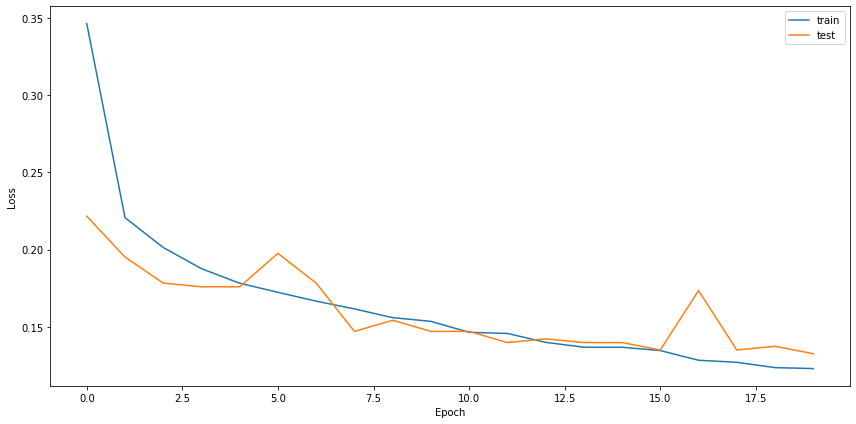

In [ ]:
def print_train_test_loss(path_to_info = "model/best_trial_info.txt"):
    with open(path_to_info, "rb") as fp:
        last_res = pickle.load(fp)
    train_l, test_l = last_res['train_list'], last_res['test_list']

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_l)), train_l, label="train")
    plt.plot(range(len(test_l)), test_l, label="test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
print_train_test_loss()

### Обучение модели

In [ ]:
# метод загрузки получившейся предобученной модели и оптимизатора
def load_best_model():

    best_trained_model = Model()
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    with open("model/config.txt", "rb") as fp:
        config = pickle.load(fp)


    best_trained_model.load_state_dict(torch.load('/content/drive/My Drive/speechGender/model/cnn_model.npy'))

    optimizer = optim.SGD(best_trained_model.parameters(), lr = config['lr'])
    optimizer.load_state_dict(torch.load('/content/drive/My Drive/speechGender/model/optim_params.npy'))

    return best_trained_model, optimizer

load_best_model()

#### Функция обучения модели на заданных гиперпараметрах

In [ ]:
def train_fix_param_model(model, config):
    epochs, batch_size, lr = config['epochs'], config['batch_size'], config['lr']
    model.cuda()

    optim = Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

    train_dataset = MelDataset(X_train, Y_train)
    test_dataset = MelDataset(X_test, Y_test)

    train_loss_all, test_loss_all = [], []

    for ep in range(epochs):
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
        test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
        total_batches_train, total_batches_test = 0, 0
        train_loss, test_loss = 0, 0
        train_acc, test_acc = 0, 0


        for i, (batch, label) in tqdm(enumerate(train_dataloader), 
                                      total=(len(train_dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches_train += 1

            batch = batch.cuda()
            label = label.cuda()
            batch = batch.reshape((batch_size, 1, 128))
            pred = model(batch)
            prob = torch.Tensor([1 if p>=0.5 else 0 for p in pred]).reshape(-1,1).cuda()
            label = label.type(torch.float)
            loss = F.binary_cross_entropy(pred, label)
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_loss += loss.item()
            train_acc += (prob == label).float().sum()

        for i, (batch, label) in enumerate(test_dataloader):
            if len(batch) < batch_size:
                continue
            total_batches_test += 1

            batch = batch.cuda()
            label = label.cuda()
            batch = batch.reshape((batch_size, 1, 128))
            pred = model(batch)
            prob = torch.Tensor([1 if p>=0.5 else 0 for p in pred]).reshape(-1,1).cuda()
            label = label.type(torch.float)
            loss = F.binary_cross_entropy(pred, label)

            test_loss += loss.item()
            test_acc += (prob == label).float().sum()
        
        train_loss_all.append(train_loss / total_batches_train)
        test_loss_all.append(test_loss / total_batches_train)
        print(f"Epoch {ep+1} | Train loss: {train_loss_all[-1]} | Test loss: {test_loss_all[-1]} | \
Train Accuracy: {100 * train_acc/len(train_dataset)} | Test Accuracy: {100 * test_acc/len(test_dataset)}")
    return train_loss_all, test_loss_all